In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from statsmodels.regression.linear_model import OLS
sys.path.append('../src')
from utils.load_bucket_prices import (
    load_bucket_prices)
from utils.get_prices import get_prices

plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (15, 5)

In [113]:
from strats.portfolio import Portfolio

from strats.tw_portfolio import (
    corr_to_benchmarks, quantile_corr_criteria,
    bottom_k_total_corr_criteria, n_day_periods)

In [111]:
start, end = '2015-01-01', '2021-03-23'

all_data = load_bucket_prices('..', start, end, basket='russell_3k')

Found existing data file. Reading...
Data read from: ../data/raw/prc_russell_3k_2015-01-01_2021-03-23_factset.csv


In [2]:
benchmarks = ['SPYV', 'SPYG', 'SPY', 'VTHR']
benchmarks_fname = f'../data/raw/prc_benchmarks_{start}_{end}_tiingo.csv'

bench_data = get_prices(
    benchmarks, start, end, out_path=benchmarks_fname)

NameError: name 'start' is not defined

In [7]:
all_data.loc[:'2016-06-28', ('adj_close', 'GMRE-US')] = np.nan
all_data.loc[:'2015-03-12', ('adj_close', 'TYME-US')] = np.nan

close_prices = all_data['adj_close']
bench_close = bench_data['adj_close']
bench_close.index = bench_close.index.tz_localize(None)

close_prices.columns = close_prices.columns.str.replace('-US', '')

# VTHR is the Vanguard tracker for Russell 3k, which is all that's available in Tiingo
bench_close = bench_close.rename(columns={'VTHR': 'RUA'})

In [8]:
holidays = set(close_prices.index) - set(bench_close.index)
close_prices = close_prices.drop(holidays)

assert close_prices.index.identical(bench_close.index)

returns = close_prices.pct_change().dropna(how='all')
bench_returns = bench_close.pct_change().dropna(how='all')

In [12]:
corrs = corr_to_benchmarks(returns, bench_returns, 63)

<AxesSubplot:xlabel='date'>

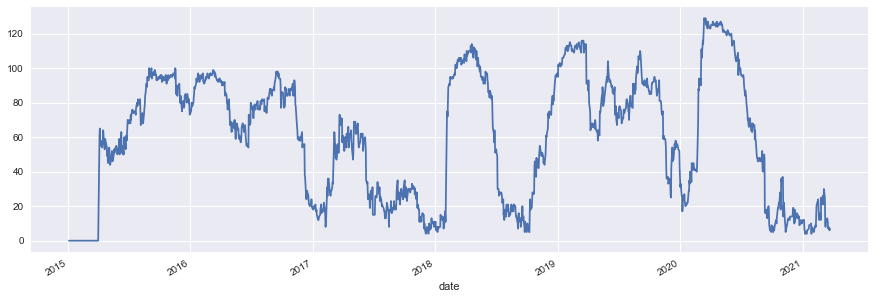

In [14]:
satisfies = quantile_corr_criteria(corrs['SPYG'], corrs['SPYV'], 0.05)
satisfies.sum(axis=1).plot()

In [23]:
benchmark_satisfies = pd.DataFrame(True, index=satisfies.index, columns=['SPYV', 'SPYG'])

# Performance Evaluations

## Across offsets and rebalancing periods

In [756]:
def run_strategy(
        periods, prices, satisfies, 
        exclude_covid=False):

    if exclude_covid:
        prices = prices.loc[:'2020-03-10']

    p = Portfolio(prices)

    buy_days = set(p.start for p in periods)
    sell_days = set(p.stop for p in periods)

    for day in satisfies.index:
        if day in sell_days:
            p.sell(day, p.tickers_held, prices.loc[day])
        if day in buy_days:
            p.buy(day, satisfies.columns[satisfies.loc[day]], prices.loc[day])
    return p

def test_strategy_grid(offsets, period_lengths, prices, satisfies):
    all_results = []

    for offset in offsets:
        for period_len in period_lengths:
#             if offset < period_len:
            periods = n_day_periods(prices.index, offset, period_len)
            p = run_strategy(periods, prices, satisfies)
            stats = p.stats()
            stats.update({'offset': offset, 'period_len': period_len})
            all_results.append(stats)
    return pd.DataFrame(all_results)

In [ ]:
random_holdings = returns.columns.to_series().sample(60)
# random_holdings = satisfies.columns[satisfies.loc['2015-04-10']]
random_satisfies = pd.DataFrame(True, index=satisfies.index, columns=random_holdings)

satisfies_fixed_100 = bottom_k_total_corr_criteria(corrs['SPYV'], corrs['SPYG'], 100)

In [768]:
satisfies_fixed_200 = bottom_k_total_corr_criteria(corrs['SPYV'], corrs['SPYG'], 200)

In [789]:
satisfies_fixed_20 = bottom_k_total_corr_criteria(corrs['SPYV'], corrs['SPYG'], 20)

In [590]:
offsets = [0, 1, 2, 3, 4, 11]
period_lengths = [2, 5, 10, 30, 60, 90, 180]

res = test_strategy_grid(
    offsets, period_lengths, close_prices, satisfies)

In [595]:
baseline_res = test_strategy_grid(
    offsets, period_lengths, bench_close, benchmark_satisfies)

In [602]:
res_random = test_strategy_grid(
    offsets, period_lengths, close_prices, random_sastisfies)

In [757]:
res_fixed_100 = test_strategy_grid(
    offsets, period_lengths, close_prices, satisfies=satisfies_fixed_100)

In [769]:
res_fixed_200 = test_strategy_grid(
    offsets, period_lengths, close_prices, satisfies=satisfies_fixed_200)

Text(0.5, 0.98, 'TW - Mean values over offsets')

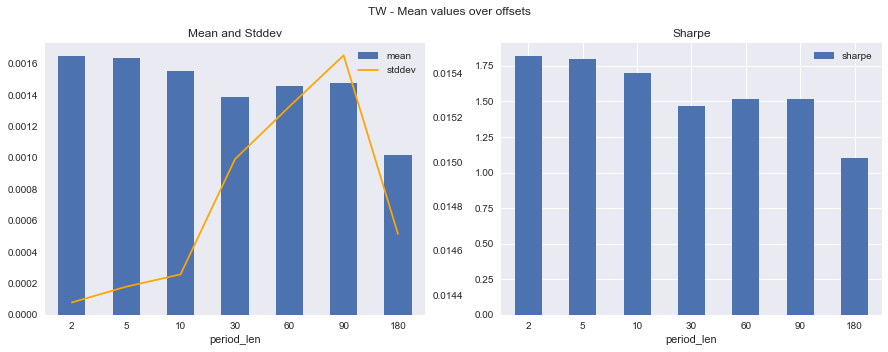

In [592]:
_ , (ax1, ax2) = plt.subplots(ncols=2)

by_period_len = res.groupby('period_len').mean().reset_index()
by_period_len.plot.bar(x='period_len', y='mean', rot=0, ax=ax1)
ax1.grid(False)
ax1 = by_period_len.plot(
    y='stddev',
    color='orange',
    secondary_y=True,
    ax=ax1, mark_right=False)
ax1.grid(False)
ax1.set_title('Mean and Stddev')

by_period_len.plot.bar(x='period_len', y='sharpe', rot=0, ax=ax2)
ax2.set_title('Sharpe')

plt.suptitle('TW - Mean values over offsets')

Text(0.5, 0.98, 'TW (Fixed k=100 holdings) - Mean values over offsets')

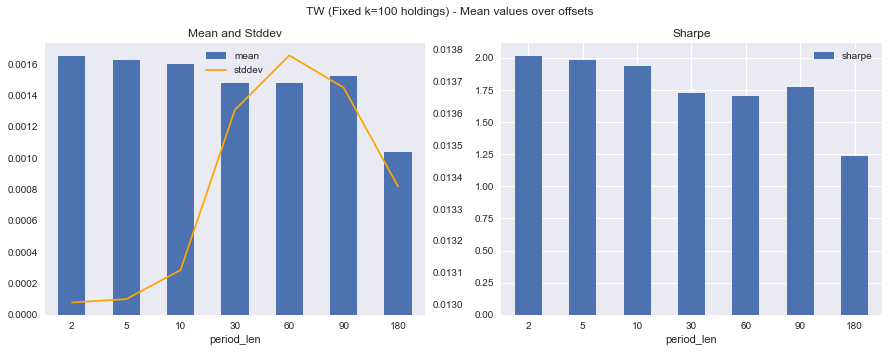

In [767]:
_ , (ax1, ax2) = plt.subplots(ncols=2)

by_period_len = res_fixed_100.groupby('period_len').mean().reset_index()
by_period_len.plot.bar(x='period_len', y='mean', rot=0, ax=ax1)
ax1.grid(False)
ax1 = by_period_len.plot(
    y='stddev',
    color='orange',
    secondary_y=True,
    ax=ax1, mark_right=False)
ax1.grid(False)
ax1.set_title('Mean and Stddev')

by_period_len.plot.bar(x='period_len', y='sharpe', rot=0, ax=ax2)
ax2.set_title('Sharpe')

plt.suptitle('TW (Fixed k=100 holdings) - Mean values over offsets')

Text(0.5, 0.98, 'TW (Fixed k=100 holdings) - Mean values over offsets')

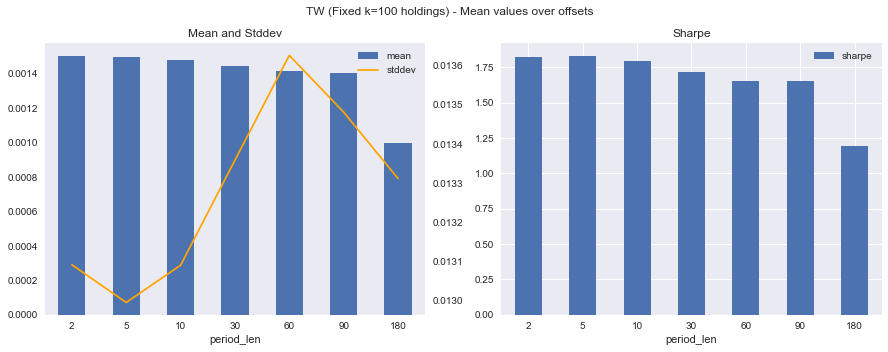

In [770]:
_ , (ax1, ax2) = plt.subplots(ncols=2)

by_period_len = res_fixed_200.groupby('period_len').mean().reset_index()
by_period_len.plot.bar(x='period_len', y='mean', rot=0, ax=ax1)
ax1.grid(False)
ax1 = by_period_len.plot(
    y='stddev',
    color='orange',
    secondary_y=True,
    ax=ax1, mark_right=False)
ax1.grid(False)
ax1.set_title('Mean and Stddev')

by_period_len.plot.bar(x='period_len', y='sharpe', rot=0, ax=ax2)
ax2.set_title('Sharpe')

plt.suptitle('TW (Fixed k=100 holdings) - Mean values over offsets')

Text(0.5, 0.98, 'TW - Maximum values over offsets')

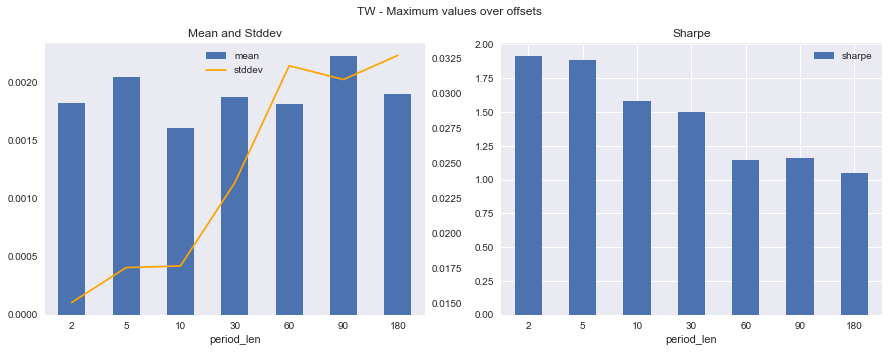

In [339]:
# _ , (ax1, ax2) = plt.subplots(ncols=2)

# by_period_len = res.groupby('period_len').max().reset_index()
# by_period_len.plot.bar(x='period_len', y='mean', rot=0, ax=ax1)
# ax1.grid(False)
# ax1 = by_period_len.plot(
#     y='stddev',
#     color='orange',
#     secondary_y=True,
#     ax=ax1, mark_right=False)
# ax1.grid(False)
# ax1.set_title('Mean and Stddev')

# by_period_len.plot.bar(x='period_len', y='sharpe', rot=0, ax=ax2)
# ax2.set_title('Sharpe')

# plt.suptitle('TW - Maximum values over offsets')

Text(0.5, 0.98, 'TW - Minimum values over offsets')

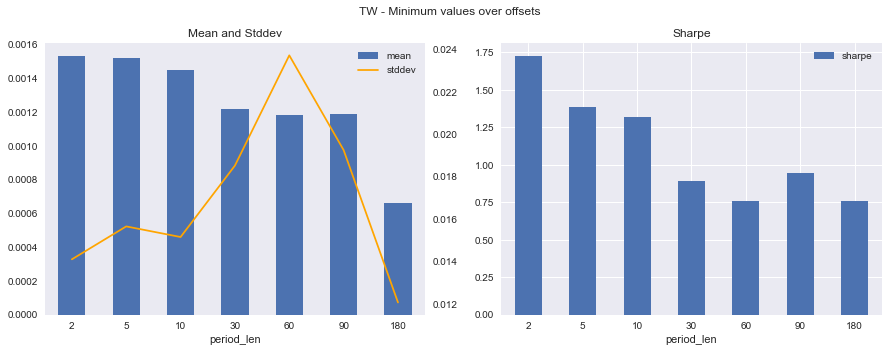

In [340]:
# _ , (ax1, ax2) = plt.subplots(ncols=2)

# by_period_len = res.groupby('period_len').min().reset_index()
# by_period_len.plot.bar(x='period_len', y='mean', rot=0, ax=ax1)
# ax1.grid(False)
# ax1 = by_period_len.plot(
#     y='stddev',
#     color='orange',
#     secondary_y=True,
#     ax=ax1, mark_right=False)
# ax1.grid(False)
# ax1.set_title('Mean and Stddev')

# by_period_len.plot.bar(x='period_len', y='sharpe', rot=0, ax=ax2)
# ax2.set_title('Sharpe')

# plt.suptitle('TW - Minimum values over offsets')

Text(0.5, 0.98, 'TW - Stddev values over offsets')

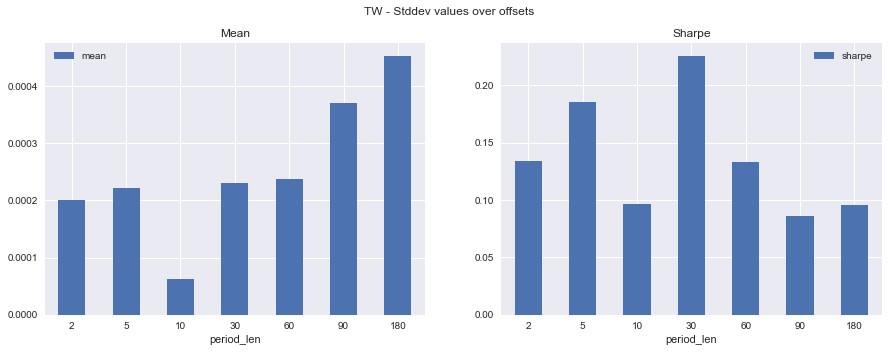

In [349]:
# _ , (ax1, ax2) = plt.subplots(ncols=2)

# by_period_len = res.groupby('period_len').std().reset_index()
# by_period_len.plot.bar(x='period_len', y='mean', rot=0, ax=ax1)
# ax1.set_title('Mean')

# by_period_len.plot.bar(x='period_len', y='sharpe', rot=0, ax=ax2)
# ax2.set_title('Sharpe')

# plt.suptitle('TW - Stddev values over offsets')

Text(0.5, 0.98, 'Quantile-based')

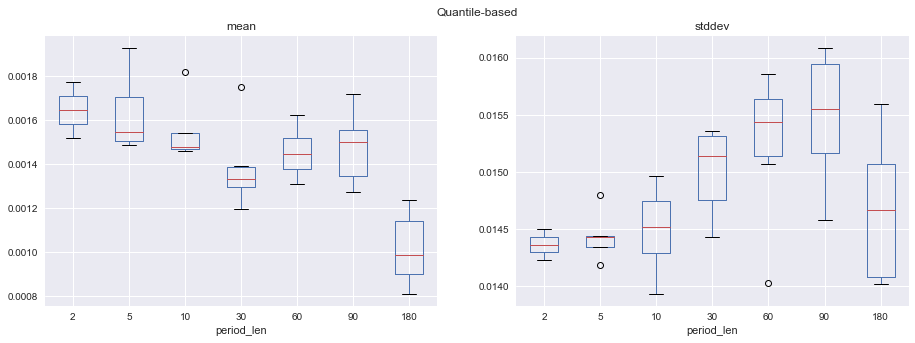

In [766]:
_, (ax1, ax2) = plt.subplots(ncols=2)
res.boxplot(column='mean', by='period_len', ax=ax1)
res.boxplot(column='stddev', by='period_len', ax=ax2)
plt.suptitle('Quantile-based')

Text(0.5, 0.98, 'Fixed # of Holdings')

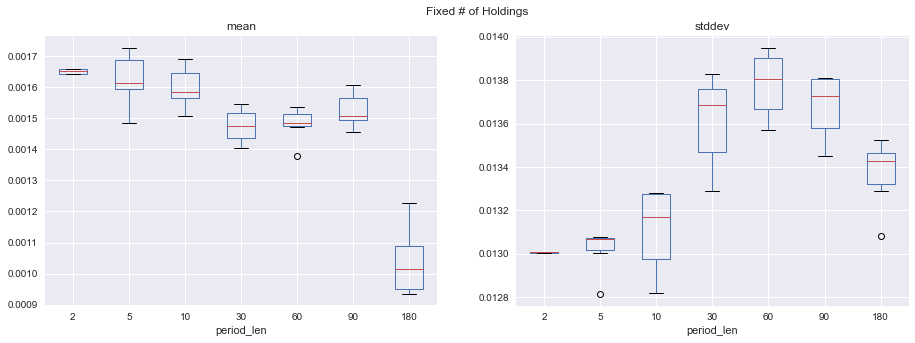

In [765]:
_, (ax1, ax2) = plt.subplots(ncols=2)
res_fixed.boxplot(column='mean', by='period_len', ax=ax1)
res_fixed.boxplot(column='stddev', by='period_len', ax=ax2)
plt.suptitle('Fixed # of Holdings')

Text(0.5, 0.98, 'Baseline - Mean values over offsets')

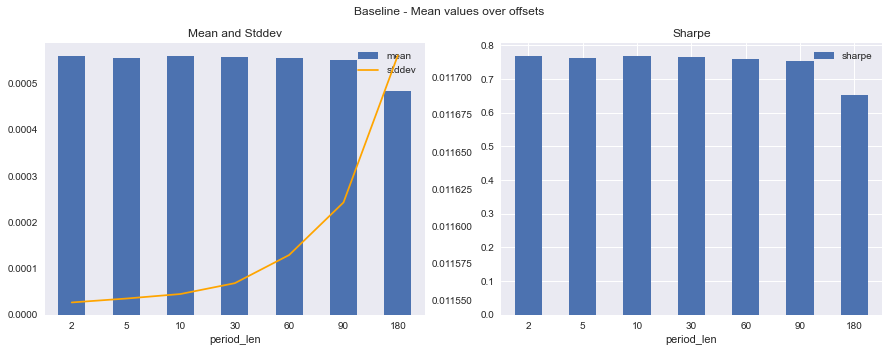

In [761]:
_ , (ax1, ax2) = plt.subplots(ncols=2)

by_period_len = baseline_res.groupby('period_len').mean().reset_index()
by_period_len.plot.bar(x='period_len', y='mean', rot=0, ax=ax1)
ax1.grid(False)
ax1 = by_period_len.plot(
    y='stddev',
    color='orange',
    secondary_y=True,
    ax=ax1, mark_right=False)
ax1.grid(False)
ax1.set_title('Mean and Stddev')

by_period_len.plot.bar(x='period_len', y='sharpe', rot=0, ax=ax2)
ax2.set_title('Sharpe')

plt.suptitle('Baseline - Mean values over offsets')

Text(0.5, 1.0, 'Baseline - Max values over offsets')

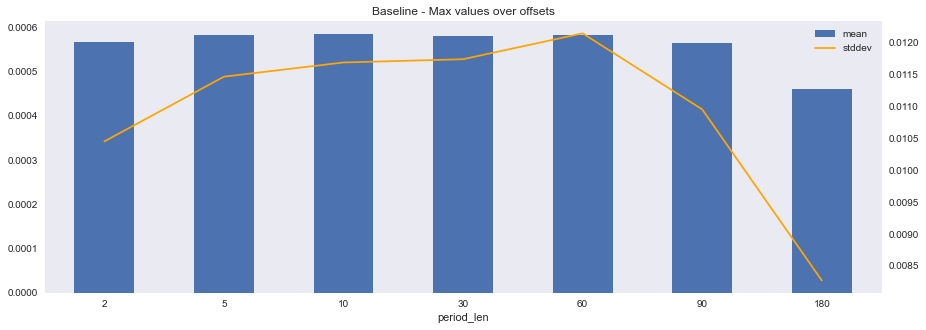

In [343]:
by_period_len = baseline_res.groupby('period_len').max().reset_index()
ax = by_period_len.plot.bar(x='period_len', y='mean', rot=0)
ax.grid(False)
ax = by_period_len.plot(
    y='stddev',
    color='orange',
    secondary_y=True,
    ax=ax, mark_right=False)
ax.grid(False)
plt.title('Baseline - Max values over offsets')

Text(0.5, 0.98, 'Baseline - Mean values over offsets')

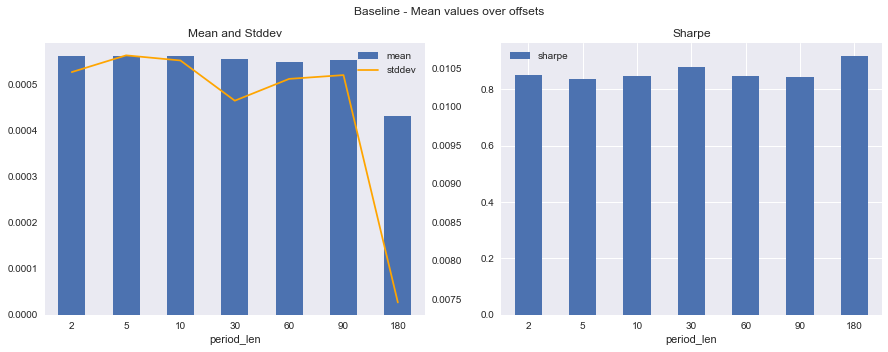

In [344]:
_ , (ax1, ax2) = plt.subplots(ncols=2)

by_period_len = baseline_res.groupby('period_len').mean().reset_index()
by_period_len.plot.bar(x='period_len', y='mean', rot=0, ax=ax1)
ax1.grid(False)
ax1 = by_period_len.plot(
    y='stddev',
    color='orange',
    secondary_y=True,
    ax=ax1, mark_right=False)
ax1.grid(False)
ax1.set_title('Mean and Stddev')

by_period_len.plot.bar(x='period_len', y='sharpe', rot=0, ax=ax2)
ax2.set_title('Sharpe')

plt.suptitle('Baseline - Mean values over offsets')

Text(0.5, 0.98, 'High threshold - Mean values over offsets')

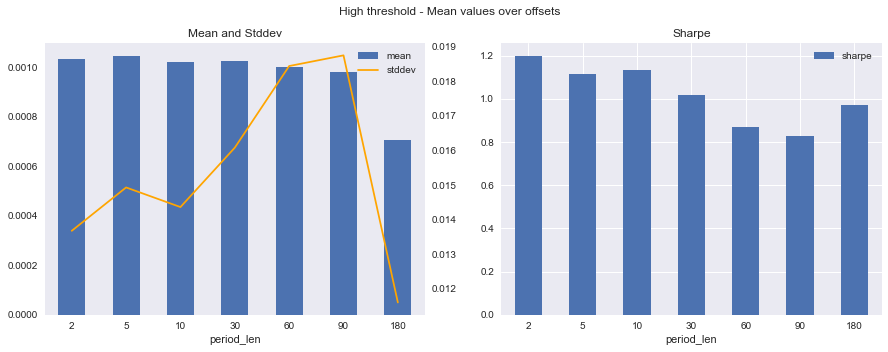

In [345]:
_ , (ax1, ax2) = plt.subplots(ncols=2)

by_period_len = res_high.groupby('period_len').mean().reset_index()
by_period_len.plot.bar(x='period_len', y='mean', rot=0, ax=ax1)
ax1.grid(False)
ax1 = by_period_len.plot(
    y='stddev',
    color='orange',
    secondary_y=True,
    ax=ax1, mark_right=False)
ax1.grid(False)
ax1.set_title('Mean and Stddev')

by_period_len.plot.bar(x='period_len', y='sharpe', rot=0, ax=ax2)
ax2.set_title('Sharpe')

plt.suptitle('High threshold - Mean values over offsets')

Text(0.5, 1.0, 'Baseline')

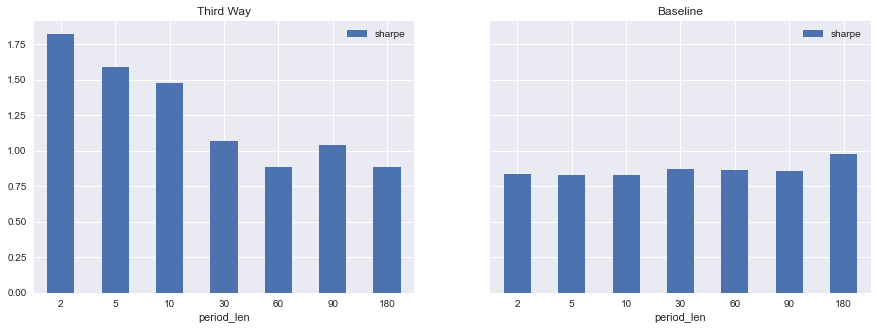

In [33]:
_ , (ax1, ax2) = plt.subplots(ncols=2, sharey=True)

by_period_len = res.groupby('period_len').mean().reset_index()
by_period_len.plot.bar(x='period_len', y='sharpe', rot=0, ax=ax1)
ax1.set_title('Third Way')

by_period_len = baseline_res.groupby('period_len').mean().reset_index()
by_period_len.plot.bar(x='period_len', y='sharpe', rot=0, ax=ax2)
ax2.set_title('Baseline')

## Point-in-time

In [35]:
periods = n_day_periods(returns.index, 0, 10)

p = run_strategy(periods, close_prices, satisfies)
bp = run_strategy(periods, bench_close, benchmark_satisfies)


print('Third Way stats:')
print(p.stats())

print('Baseline stats:')
print(bp.stats())

Third Way stats:
{'mean': 0.001474171109860287, 'stddev': 0.01610310782060552, 'sharpe': 1.4532437552168371, 'num_traded_days': 149}
Baseline stats:
{'mean': 0.0005640450724170498, 'stddev': 0.011336369121709516, 'sharpe': 0.7898417776406474, 'num_traded_days': 156}


In [37]:
# _, (ax1, ax2) = plt.subplots(ncols=2)

# p.cumulative_returns.plot(ax=ax1)
# ax1.set_title('TW')

# bp.cumulative_returns.plot(ax=ax2)
# ax2.set_title('Baseline')

# plt.suptitle('Cumulative Returns')

<AxesSubplot:xlabel='date'>

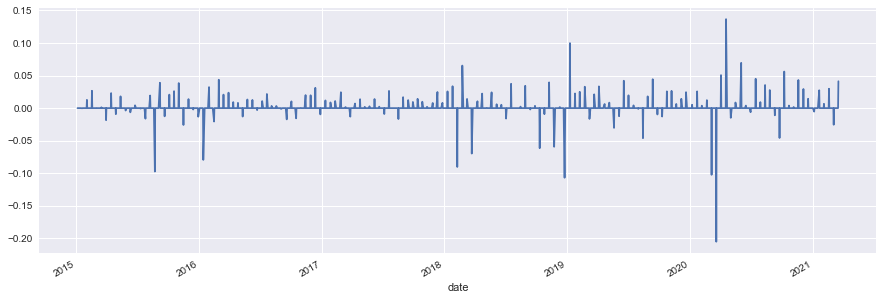

In [38]:
p_returns = p.returns.mean(axis=1)
bp_returns = bp.returns.mean(axis=1)

bp_returns.plot()

<AxesSubplot:ylabel='Proportion'>

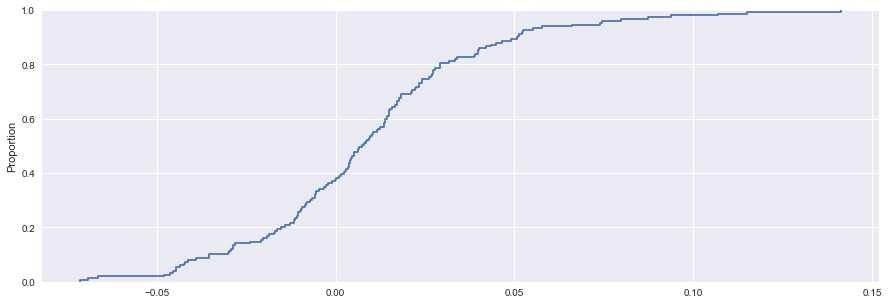

In [39]:
traded_days = (bp_returns != 0) & (p_returns != 0)
sns.ecdfplot((p_returns  - bp_returns)[traded_days])

In [40]:
from scipy.stats import ttest_ind

ttest_ind(
    p.returns.mean(axis=1)[p.returns.mean(axis=1) != 0].dropna(),
    bp.returns.mean(axis=1)[bp.returns.mean(axis=1) != 0].dropna())

Ttest_indResult(statistic=1.8600407028124042, pvalue=0.06384862486618985)

<AxesSubplot:xlabel='date'>

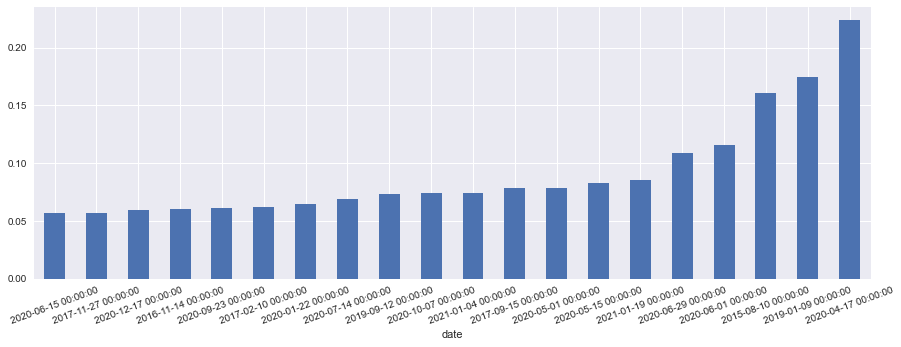

In [41]:
p_returns.sort_values().tail(20).plot.bar(rot=20)

<AxesSubplot:xlabel='date'>

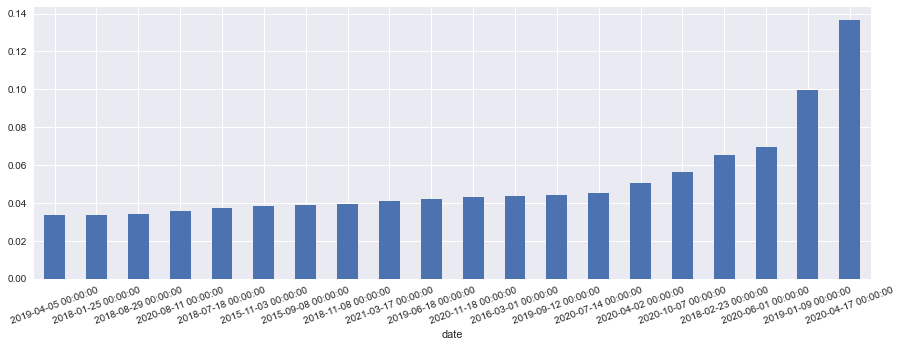

In [42]:
bp_returns.sort_values().tail(20).plot.bar(rot=20)

<AxesSubplot:ylabel='Frequency'>

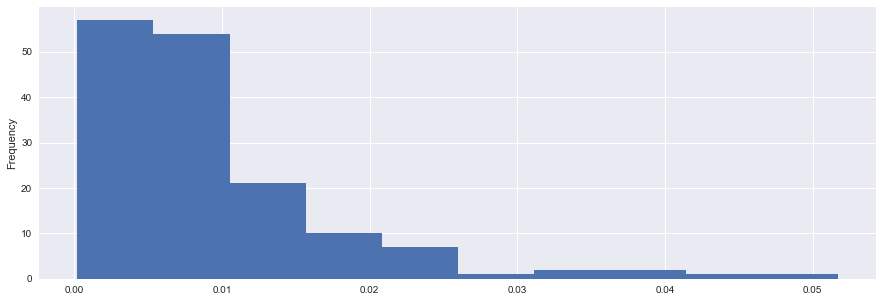

In [44]:
max_min_return_diff = bp.returns.std(axis=1)

max_min_return_diff[max_min_return_diff != 0].plot.hist()

<AxesSubplot:ylabel='Frequency'>

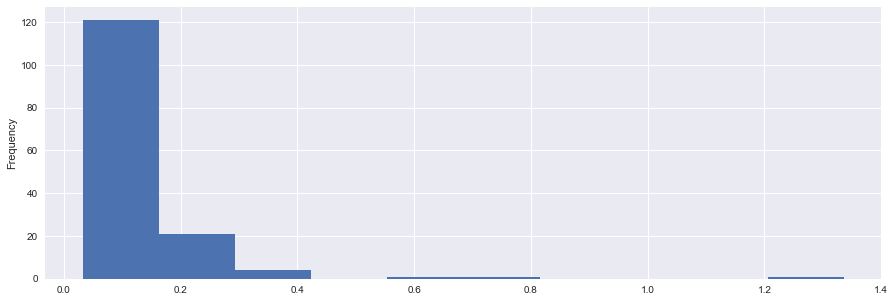

In [45]:
max_min_return_diff = p.returns.std(axis=1)

max_min_return_diff[max_min_return_diff != 0].plot.hist()

<AxesSubplot:xlabel='date'>

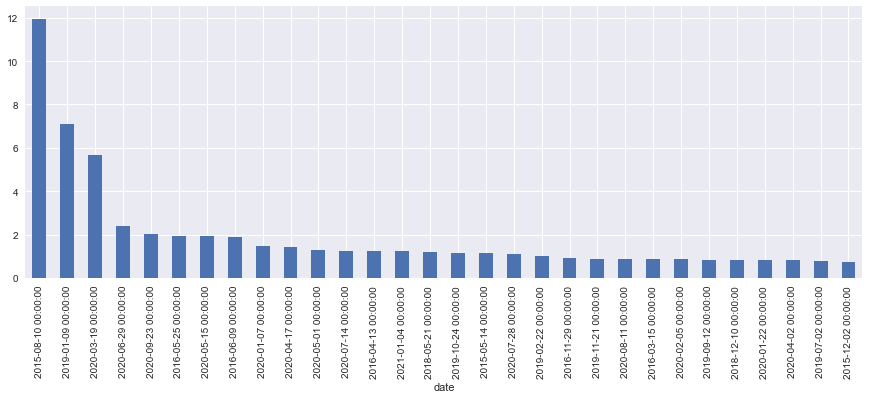

In [2576]:
p.returns.max(axis=1)[p_returns != 0].sort_values(ascending=False).head(30).plot.bar()

<AxesSubplot:xlabel='date'>

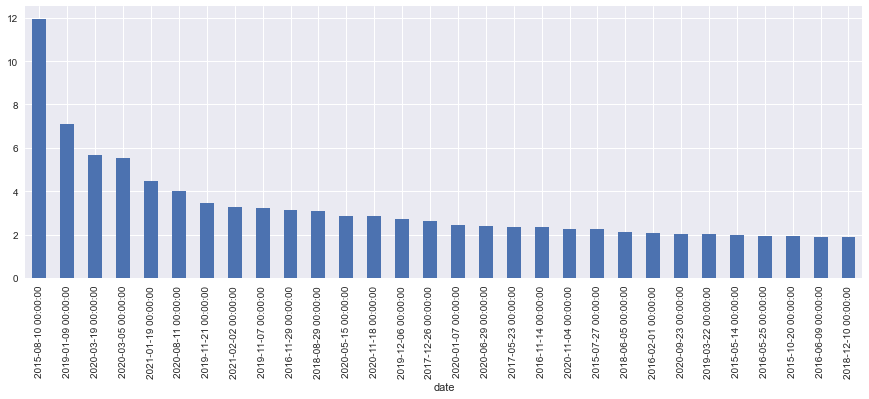

In [2577]:
bp.returns.max(axis=1)[bp_returns != 0].sort_values(ascending=False).head(30).plot.bar()

# Portfolio Constituents

## Most common qualifiers

In [47]:
common_qualifiers = satisfies.sum(axis=0).sort_values().tail(30)
common_qualifiers

symbols
UBFO    324
FVCB    325
RLMD    327
XPEL    328
INDT    328
GORO    328
PAYS    331
BSGM    332
EVFM    337
ATEC    338
RGLD    339
ELOX    354
MCBS    359
OTRK    360
DMTK    361
FCCY    361
OPRX    373
BCLI    374
AWH     378
PRPL    379
TRNS    382
APT     387
VBIV    391
VXRT    408
MFNC    408
BFC     408
COFS    411
IBIO    428
MNSB    500
WKHS    567
dtype: int64

## Most often bought in sample run

In [48]:
common_bought = p.buy_signals.sum().sort_values(ascending=False).head(30)
common_bought

symbols
WKHS    58.0
MNSB    52.0
IBIO    43.0
COFS    41.0
PRPL    40.0
DMTK    40.0
VBIV    40.0
BCLI    39.0
TRNS    39.0
XPEL    38.0
MFNC    38.0
ATEC    38.0
VXRT    37.0
OTRK    37.0
BFC     37.0
MCBS    36.0
AWH     36.0
FVCB    36.0
FCCY    36.0
OPRX    36.0
BSGM    36.0
ELOX    35.0
RGLD    35.0
CVM     35.0
PAYS    34.0
APT     34.0
INDT    33.0
EVFM    33.0
RVSB    33.0
INS     33.0
dtype: float64

In [49]:
in_both = common_bought.index.intersection(common_qualifiers.index)
print(len(in_both), 'between the top 30 of each are shared')
in_both

27 between the top 30 of each are shared


Index(['WKHS', 'MNSB', 'IBIO', 'COFS', 'PRPL', 'DMTK', 'VBIV', 'BCLI', 'TRNS',
       'XPEL', 'MFNC', 'ATEC', 'VXRT', 'OTRK', 'BFC', 'MCBS', 'AWH', 'FVCB',
       'FCCY', 'OPRX', 'BSGM', 'ELOX', 'RGLD', 'PAYS', 'APT', 'INDT', 'EVFM'],
      dtype='object', name='symbols')

Those not shared still frequently satisfy the criteria

In [50]:
satisfies.sum()[common_bought.index.symmetric_difference(in_both)]

symbols
CVM     318
INS     320
RVSB    304
dtype: int64

In [662]:
def ticker_name_tiingo(ticker):
    import requests
    
    url = f'https://api.tiingo.com/tiingo/daily/{ticker}?token=9a73b39f64bb2c32bbc0a52fb5ff970c2929f241'

    headers = {
        'Content-Type': 'application/json'
    }
    resp = requests.get(url, headers=headers)
    return resp.json()

def ticker_all_names(tickers):
    all_data = []
    for tick in tickers:
        data = ticker_name_tiingo(tick)
        all_data.append(data)
    return all_data

name_data = ticker_all_names(common_bought.index)

In [666]:
pd.DataFrame(name_data)[['name', 'ticker', 'description']]

,name,ticker,description
0,Misonix Inc,MSON,"Misonix, Inc. is a provider of minimally invas..."
1,United Security Bancshares (CA),UBFO,United Security Bancshares is the holding comp...
2,VBI Vaccines Inc,VBIV,VBI Vaccines Inc. (“VBI”) is a biopharmaceutic...
3,Farmers & Merchants Bancorp Inc,FMAO,The Farmers & Merchants State Bank is a local ...
4,Gold Resource Corporation,GORO,Gold Resource Corporation is engaged in the ex...
5,Aspen Group Inc,ASPU,"Aspen Group, Inc. is an education technology h..."
6,First Capital Inc,FCAP,"First Capital, Inc. (First Capital), is a hold..."
7,FVCBankcorp Inc,FVCB,FVCbankcorp Inc
8,Riverview Bancorp Inc,RVSB,"Riverview Bancorp, Inc. (Riverview) is a savin..."
9,MetroCity Bankshares Inc,MCBS,"MetroCity Bankshares, Inc. is a Georgia corpor..."


In [667]:
finance = ['UBFO', 'FMAO', 'FCAP', 'FVCB', 'RVSB', 'MCBS', 'COFS', 'FCCY', 'MFNC', 'BFC', 'MNSB']

bio = ['VBI', 'RLMD', 'BSGM', 'OPRX', 'ELOX', 'EVFM', 'ATEC', 'TRNS']
health_tech = ['MISONIX', 'OTRK']

mining = ['GORO']

other = ['ASPU', 'VVNT', 'INDT', 'INS', 'PAYS', 'XPEL', 'PRPL', 'WKHS'] # INS maybe financial # PAYS maybe financial

In [2406]:
len(finance), len(bio), len(health_tech), len(mining), len(other)

(11, 8, 2, 1, 8)

In [669]:
len(finance + bio + health_tech + mining + other)

30

In [673]:
holding_2017 = p.holdings.loc['2017-01-30'].dropna().index
holding_2017 = pd.DataFrame(ticker_all_names(holding_2017))

In [675]:
holding_2017

,startDate,exchangeCode,description,ticker,name,endDate
0,2006-08-02,NASDAQ,Anavex Life Sciences Corp. is a publicly trade...,AVXL,Anavex Life Sciences Corporation,2021-04-05
1,2012-07-10,NASDAQ,"FS Bancorp, Inc., a Washington corporation, is...",FSBW,FS Bancorp Inc,2021-04-05
2,2014-03-25,NASDAQ,"Marker Therapeutics, Inc. is a clinical-stage ...",MRKR,Marker Therapeutics Inc,2021-04-05
3,2014-06-13,NYSE,Aspen is a technology leader in sustainability...,ASPN,Aspen Aerogels Inc,2021-04-05
4,2014-06-04,NASDAQ,Pacific City Financial Corporation is the bank...,PCB,PCB Bancorp.,2021-04-05
5,2014-07-17,NASDAQ,"CareDx, Inc., headquartered in South San Franc...",CDNA,Caredx Inc,2021-04-05
6,2012-10-03,NYSE,Luxfer is a global manufacturer of highly-engi...,LXFR,Luxfer Holdings PLC,2021-04-05
7,2001-01-02,NASDAQ,Franklin Financial Services Corporation is a b...,FRAF,Franklin Financial Services Corp,2021-04-05
8,1973-05-03,NYSE,BRT is a real estate investment trust that dir...,BRT,BRT Apartments Corp,2021-04-05
9,2015-11-20,NASDAQ,,AKTS,Akoustis Technologies Inc,2021-04-05


In [680]:
holding_2019 = p.holdings.loc['2019-09-30'].dropna().index
holding_2019 = pd.DataFrame(ticker_all_names(holding_2019))

In [684]:
holding_2019.head(30)

,startDate,exchangeCode,description,ticker,name,endDate
0,2006-06-02,NASDAQ,"Alphatec Holdings, Inc. (ATEC), through its wh...",ATEC,Alphatec Holdings Inc,2021-04-05
1,2000-09-28,NASDAQ,DURECT is a biopharmaceutical company committe...,DRRX,Durect Corp,2021-04-05
2,2004-05-27,NASDAQ,ACADIA is a biopharmaceutical company focused ...,ACAD,Acadia Pharmaceuticals Inc,2021-04-05
3,2012-07-02,NASDAQ,Liberty Tax Inc,FRG,Franchise Group Inc - Class A,2021-04-05
4,2014-10-09,NASDAQ,Relmada Therapeutics is a late-stage pharmaceu...,RLMD,Relmada Therapeutics Inc,2021-04-05
5,1989-12-20,NASDAQ,"Sanderson Farms, Inc. is a poultry processing ...",SAFM,Sanderson Farms Inc,2021-04-05
6,1996-11-06,NASDAQ,SeaChange International powers hundreds of clo...,SEAC,Seachange International Inc,2021-04-05
7,2012-07-25,NYSE,"Natural Grocers by Vitamin Cottage, Inc. is an...",NGVC,Natural Grocers by Vitamin Cottage Inc,2021-04-05
8,2016-01-04,NASDAQ,,ADVM,Adverum Biotechnologies Inc,2021-04-05
9,2010-07-22,NYSE,Green Dot Corporation is a financial technolog...,GDOT,Green Dot Corp - Class A,2021-04-05


# Fama-French Analysis

In [64]:
from utils.fama_french import (
    read_monthly_ff_file, read_daily_ff_file,
    run_aligned_ols, returns_over_periods,
    returns_over_periods_from_prices, monthly_returns)

In [54]:
ff_5 = read_daily_ff_file('../data/alternative/fama_french_5_factors_daily.csv')
ff_5.shape, close_prices.shape

((14514, 6), (1566, 2848))

## 10-day Rebalancing

Rollup daily Fama-French factors to align returns with the trading days of the portfolio

In [60]:
holding_len = 10

periods = n_day_periods(close_prices.index, 0, holding_len)

p = run_strategy(periods, close_prices.iloc[1:], satisfies)
bp = run_strategy(periods, bench_close, benchmark_satisfies)

ff_5_aligned = ff_5.loc[periods[0].start:periods[-1].stop - pd.Timedelta(days=1)]
ff_5_aligned = returns_over_periods(ff_5_aligned, periods).drop(['RF', 'CMA'], axis=1)

### Including covid

In [63]:
run_aligned_ols(
    p.returns.mean(axis=1)[p.sell_signals.index],
    ff_5_aligned).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.550
Model:                            OLS   Adj. R-squared:                  0.538
Method:                 Least Squares   F-statistic:                     43.77
Date:                Fri, 09 Apr 2021   Prob (F-statistic):           6.03e-24
Time:                        12:06:10   Log-Likelihood:                 281.49
No. Observations:                 148   AIC:                            -553.0
Df Residuals:                     143   BIC:                            -538.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0130      0.003      4.185      0.000       0.007       0.019
Mkt-RF         0.8491      0.107      7.938      0.000       0.638       1.061
SMB            0.6783      0.188      3.605      0.000       0.306       1.050
HML           -0.2346      0.134     -1.748      0.083      -0.500       0.031
RMW           -0.6530      0.233     -2.807      0.006      -1.113      -0.193
==============================================================================
Omnibus:                       12.451   Durbin-Watson:                   2.095
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               20.868
Skew:                           0.403   Prob(JB):                     2.94e-05
Kurtosis:                       4.654   Cond. No.                         86.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Excluding covid

In [61]:
run_aligned_ols(
    p.returns.mean(axis=1)[p.sell_signals.index][:'2020-03-01'],
    ff_5_aligned).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.443
Model:                            OLS   Adj. R-squared:                  0.424
Method:                 Least Squares   F-statistic:                     23.23
Date:                Fri, 09 Apr 2021   Prob (F-statistic):           3.79e-14
Time:                        12:05:53   Log-Likelihood:                 268.91
No. Observations:                 122   AIC:                            -527.8
Df Residuals:                     117   BIC:                            -513.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0127      0.003      4.956      0.000       0.008       0.018
Mkt-RF         0.6658      0.107      6.210      0.000       0.454       0.878
SMB            0.6138      0.174      3.520      0.001       0.268       0.959
HML           -0.1312      0.132     -0.990      0.324      -0.394       0.131
RMW           -0.2350      0.212     -1.107      0.270      -0.655       0.185
==============================================================================
Omnibus:                       20.420   Durbin-Watson:                   1.880
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.415
Skew:                           0.953   Prob(JB):                     3.03e-06
Kurtosis:                       4.170   Cond. No.                         89.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Benchmark

In [2605]:
base_returns = bp.returns.mean(axis=1)[bp.sell_signals.index]
run_aligned_ols(base_returns, ff_5_aligned).summary()

Shapes before: (156,) (155, 4)
Shapes after: (155,) (155, 4)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.798
Method:                 Least Squares   F-statistic:                     153.5
Date:                Fri, 09 Apr 2021   Prob (F-statistic):           5.89e-52
Time:                        09:34:24   Log-Likelihood:                 433.00
No. Observations:                 155   AIC:                            -856.0
Df Residuals:                     150   BIC:                            -840.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.001      0.500      0.618      -0.002       0.003
Mkt-RF         0.9173      0.043     21.344      0.000       0.832       1.002
SMB           -0.0740      0.076     -0.975      0.331      -0.224       0.076
HML            0.0522      0.054      0.962      0.338      -0.055       0.160
RMW           -0.0329      0.093     -0.352      0.725      -0.217       0.152
==============================================================================
Omnibus:                       39.281   Durbin-Watson:                   2.651
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              337.075
Skew:                          -0.532   Prob(JB):                     6.38e-74
Kurtosis:                      10.146   Cond. No.                         86.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Daily

In [74]:
daily_p = run_strategy(n_day_periods(satisfies.index, 0, 1), close_prices, satisfies)
daily_tw_returns = daily_p.returns.mean(axis=1)[daily_p.sell_signals.index]
daily_p.stats()

{'mean': 0.0014725496611951814,
 'stddev': 0.014280987948059999,
 'sharpe': 1.6368616278725125,
 'num_traded_days': 1502}

### Including covid

In [77]:
run_aligned_ols(daily_tw_returns, ff_5).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.567
Model:                            OLS   Adj. R-squared:                  0.566
Method:                 Least Squares   F-statistic:                     323.0
Date:                Fri, 09 Apr 2021   Prob (F-statistic):          1.18e-264
Time:                        12:12:58   Log-Likelihood:                 4827.8
No. Observations:                1485   AIC:                            -9642.
Df Residuals:                    1478   BIC:                            -9605.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.000      2.755      0.006       0.000       0.002
Mkt-RF         0.7320      0.022     33.816      0.000       0.690       0.774
SMB            0.7081      0.041     17.115      0.000       0.627       0.789
HML           -0.0944      0.038     -2.513      0.012      -0.168      -0.021
RMW           -0.4840      0.064     -7.575      0.000      -0.609      -0.359
CMA            0.0523      0.078      0.674      0.501      -0.100       0.205
RF             2.7207      7.031      0.387      0.699     -11.072      16.513
==============================================================================
Omnibus:                      185.234   Durbin-Watson:                   1.944
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1783.981
Skew:                           0.148   Prob(JB):                         0.00
Kurtosis:                       8.361   Cond. No.                     2.88e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.88e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Excluding covid

In [89]:
run_aligned_ols(daily_tw_returns.loc[:'2020-03-01'], ff_5.drop('RF', axis=1)).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.451
Model:                            OLS   Adj. R-squared:                  0.448
Method:                 Least Squares   F-statistic:                     201.5
Date:                Fri, 09 Apr 2021   Prob (F-statistic):          5.86e-157
Time:                        12:18:01   Log-Likelihood:                 4389.9
No. Observations:                1234   AIC:                            -8768.
Df Residuals:                    1228   BIC:                            -8737.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.000      5.067      0.000       0.001       0.001
Mkt-RF         0.5706      0.024     23.782      0.000       0.523       0.618
SMB            0.6028      0.040     14.998      0.000       0.524       0.682
HML           -0.1576      0.044     -3.565      0.000      -0.244      -0.071
RMW           -0.1571      0.059     -2.646      0.008      -0.274      -0.041
CMA            0.2372      0.075      3.154      0.002       0.090       0.385
==============================================================================
Omnibus:                      374.450   Durbin-Watson:                   1.941
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2952.364
Skew:                           1.179   Prob(JB):                         0.00
Kurtosis:                      10.201   Cond. No.                         412.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Benchmark

In [107]:
run_aligned_ols(
    bench_close[['SPYV', 'SPYG']].pct_change().dropna().mean(axis=1),
    ff_5.drop('RF', axis=1)).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                 3.923e+04
Date:                Fri, 09 Apr 2021   Prob (F-statistic):               0.00
Time:                        12:25:32   Log-Likelihood:                 8465.2
No. Observations:                1548   AIC:                        -1.692e+04
Df Residuals:                    1542   BIC:                        -1.689e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.021e-05    2.6e-05      0.776      0.438   -3.09e-05    7.13e-05
Mkt-RF         0.9763      0.002    419.393      0.000       0.972       0.981
SMB           -0.1041      0.004    -23.429      0.000      -0.113      -0.095
HML            0.0585      0.004     14.417      0.000       0.051       0.066
RMW            0.0590      0.007      8.575      0.000       0.046       0.073
CMA            0.0291      0.008      3.466      0.001       0.013       0.046
==============================================================================
Omnibus:                      218.446   Durbin-Watson:                   2.479
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1477.500
Skew:                           0.456   Prob(JB):                         0.00
Kurtosis:                       7.698   Cond. No.                         337.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Monthly

Go the other way - roll up daily TW returns to compare to the monthly FF returns

In [73]:
monthly_tw = monthly_returns(daily_tw_returns)
monthly_spy = monthly_returns(bench_close['SPY'], is_return_series=False)

# To sanity check the `monthly_returns` function.
handrolled_monthly_ff = monthly_returns(ff_5)

In [69]:
ff_monthly = read_monthly_ff_file('../data/alternative/fama_french_5_factors_monthly.csv')
ff_monthly = ff_monthly.drop('RF', axis=1)

Comparing the monthly FF as downloaded from French's site to our monthly roll-up of daily values, they are close enough that the roll-up is likely correct.

In [71]:
ff_monthly.head(10)

,Mkt-RF,SMB,HML,RMW,CMA
1963-07,-0.0039,-0.0045,-0.0094,0.0066,-0.0115
1963-08,0.0507,-0.0082,0.0182,0.0040,-0.0040
1963-09,-0.0157,-0.0048,0.0017,-0.0076,0.0024
1963-10,0.0253,-0.0130,-0.0004,0.0275,-0.0224
1963-11,-0.0085,-0.0085,0.0170,-0.0045,0.0222
1963-12,0.0183,-0.0190,-0.0006,0.0007,-0.0030
1964-01,0.0224,0.0008,0.0153,0.0022,0.0150
1964-02,0.0154,0.0031,0.0286,0.0006,0.0085
1964-03,0.0141,0.0140,0.0337,-0.0201,0.0293
1964-04,0.0010,-0.0150,-0.0066,-0.0135,-0.0108


In [72]:
handrolled_monthly_ff.head(10)

,Mkt-RF,SMB,HML,RMW,CMA,RF
1963-07,-0.004027,-0.004612,-0.009495,0.006694,-0.011679,0.002643
1963-08,0.050801,-0.007805,0.016792,0.003688,-0.003824,0.002423
1963-09,-0.015728,-0.004244,0.000565,-0.007802,0.001468,0.002804
1963-10,0.025101,-0.013304,0.000675,0.026870,-0.020881,0.002994
1963-11,-0.008481,-0.008933,0.017980,-0.005045,0.022244,0.002703
1963-12,0.018252,-0.018517,-0.001439,0.001136,-0.003212,0.002944
1964-01,0.022060,0.000525,0.015588,0.001575,0.014766,0.002864
1964-02,0.015485,0.003090,0.028103,0.000573,0.008286,0.002663
1964-03,0.014151,0.013446,0.033243,-0.019447,0.028554,0.003155
1964-04,0.001181,-0.014833,-0.006026,-0.013071,-0.010785,0.002864


### Benchmark

In [2743]:
run_aligned_ols(monthly_spy, ff_monthly).summary()

Shapes before: (75,) (692, 5)
Shapes after: (74,) (74, 5)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    SPY   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.934
Method:                 Least Squares   F-statistic:                     207.7
Date:                Fri, 09 Apr 2021   Prob (F-statistic):           9.34e-40
Time:                        10:46:02   Log-Likelihood:                 226.43
No. Observations:                  74   AIC:                            -440.9
Df Residuals:                      68   BIC:                            -427.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0012      0.001     -0.797      0.428      -0.004       0.002
Mkt-RF         0.9858      0.036     27.378      0.000       0.914       1.058
SMB           -0.0314      0.063     -0.502      0.617      -0.156       0.094
HML            0.0346      0.056      0.623      0.536      -0.076       0.145
RMW            0.2862      0.100      2.849      0.006       0.086       0.487
CMA            0.0731      0.097      0.757      0.452      -0.120       0.266
==============================================================================
Omnibus:                       18.891   Durbin-Watson:                   1.821
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.860
Skew:                           0.957   Prob(JB):                     1.99e-07
Kurtosis:                       5.519   Cond. No.                         78.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Including covid

In [83]:
run_aligned_ols(monthly_tw, ff_monthly).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.588
Model:                            OLS   Adj. R-squared:                  0.557
Method:                 Least Squares   F-statistic:                     18.57
Date:                Fri, 09 Apr 2021   Prob (F-statistic):           2.05e-11
Time:                        12:14:59   Log-Likelihood:                 117.15
No. Observations:                  71   AIC:                            -222.3
Df Residuals:                      65   BIC:                            -208.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0182      0.006      2.994      0.004       0.006       0.030
Mkt-RF         1.0049      0.153      6.572      0.000       0.700       1.310
SMB            0.7393      0.264      2.799      0.007       0.212       1.267
HML           -0.4394      0.229     -1.920      0.059      -0.897       0.018
RMW           -0.5230      0.424     -1.234      0.222      -1.369       0.323
CMA            0.1078      0.399      0.270      0.788      -0.688       0.904
==============================================================================
Omnibus:                       15.837   Durbin-Watson:                   1.668
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               53.756
Skew:                           0.425   Prob(JB):                     2.12e-12
Kurtosis:                       7.177   Cond. No.                         79.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Excluding covid

In [108]:
run_aligned_ols(monthly_tw.loc[:'2020-03-01'], ff_monthly).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.646
Model:                            OLS   Adj. R-squared:                  0.613
Method:                 Least Squares   F-statistic:                     19.69
Date:                Fri, 09 Apr 2021   Prob (F-statistic):           4.09e-11
Time:                        12:26:17   Log-Likelihood:                 118.96
No. Observations:                  60   AIC:                            -225.9
Df Residuals:                      54   BIC:                            -213.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0208      0.005      4.363      0.000       0.011       0.030
Mkt-RF         0.8040      0.137      5.867      0.000       0.529       1.079
SMB            0.8225      0.215      3.822      0.000       0.391       1.254
HML           -0.3192      0.195     -1.634      0.108      -0.711       0.072
RMW           -0.7476      0.356     -2.100      0.040      -1.461      -0.034
CMA            0.2205      0.353      0.625      0.535      -0.487       0.928
==============================================================================
Omnibus:                       39.442   Durbin-Watson:                   1.942
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              169.919
Skew:                           1.713   Prob(JB):                     1.27e-37
Kurtosis:                      10.499   Cond. No.                         85.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Industry Analysis

In [2747]:
ff_industries = read_monthly_ff_file('../data/alternative/fama_french_industry_30_value_weighted_monthly.csv')
ff_industries_daily = read_daily_ff_file('../data/alternative/fama_french_industry_30_value_weighted_daily.csv')

### S&P

In [2749]:
run_aligned_ols(monthly_spy, ff_industries).summary()

Shapes before: (75,) (1136, 30)
Shapes after: (74,) (74, 30)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    SPY   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                     37.50
Date:                Fri, 09 Apr 2021   Prob (F-statistic):           2.66e-22
Time:                        10:46:26   Log-Likelihood:                 245.40
No. Observations:                  74   AIC:                            -428.8
Df Residuals:                      43   BIC:                            -357.4
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0024      0.002     -1.275      0.209      -0.006       0.001
Food          -0.1087      0.112     -0.968      0.338      -0.335       0.118
Beer           0.0401      0.083      0.485      0.630      -0.127       0.207
Smoke          0.0287      0.036      0.807      0.424      -0.043       0.100
Games         -0.0613      0.048     -1.271      0.211      -0.159       0.036
Books         -0.0558      0.058     -0.970      0.338      -0.172       0.060
Hshld         -0.0613      0.087     -0.709      0.482      -0.236       0.113
Clths          0.0802      0.045      1.771      0.084      -0.011       0.172
Hlth           0.1434      0.073      1.969      0.055      -0.004       0.290
Chems          0.0495      0.062      0.805      0.425      -0.075       0.174
Txtls         -0.0333      0.032     -1.055      0.297      -0.097       0.030
Cnstr          0.0869      0.072      1.198      0.237      -0.059       0.233
Steel         -0.0001      0.045     -0.003      0.998      -0.090       0.090
FabPr          0.0301      0.096      0.315      0.754      -0.163       0.223
ElcEq         -0.0996      0.097     -1.029      0.309      -0.295       0.096
Autos          0.0275      0.025      1.090      0.282      -0.023       0.078
Carry          0.0293      0.040      0.724      0.473      -0.052       0.111
Mines          0.0340      0.038      0.901      0.373      -0.042       0.110
Coal          -0.0328      0.015     -2.204      0.033      -0.063      -0.003
Oil            0.1084      0.031      3.517      0.001       0.046       0.171
Util           0.1348      0.058      2.331      0.025       0.018       0.252
Telcm          0.1087      0.082      1.333      0.189      -0.056       0.273
Servs          0.1644      0.091      1.814      0.077      -0.018       0.347
BusEq          0.1392      0.062      2.243      0.030       0.014       0.264
Paper         -0.0881      0.096     -0.921      0.362      -0.281       0.105
Trans          0.0239      0.066      0.362      0.719      -0.109       0.157
Whlsl          0.0346      0.100      0.347      0.731      -0.167       0.236
Rtail          0.1319      0.075      1.764      0.085      -0.019       0.283
Meals          0.0724      0.058      1.254      0.217      -0.044       0.189
Fin            0.0878      0.078      1.120      0.269      -0.070       0.246
Other         -0.0418      0.088     -0.474      0.638      -0.220       0.136
==============================================================================
Omnibus:                        0.463   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.794   Jarque-Bera (JB):                0.605
Skew:                           0.157   Prob(JB):                        0.739
Kurtosis:                       2.687   Cond. No.                         115.
==

### TW

In [2750]:
ff_industries.columns

Index(['Food', 'Beer', 'Smoke', 'Games', 'Books', 'Hshld', 'Clths', 'Hlth',
       'Chems', 'Txtls', 'Cnstr', 'Steel', 'FabPr', 'ElcEq', 'Autos', 'Carry',
       'Mines', 'Coal', 'Oil', 'Util', 'Telcm', 'Servs', 'BusEq', 'Paper',
       'Trans', 'Whlsl', 'Rtail', 'Meals', 'Fin', 'Other'],
      dtype='object')

#### Month-aligned

In [2790]:
to_test = pd.concat((ff_industries, ff_monthly), axis=1)
to_test = to_test[[
    'Fin', 'Hlth', 'Hshld', 'Rtail', 'Oil',
    'SMB', 'HML', 'RMW', 'CMA']]
run_aligned_ols(monthly_tw, to_test).summary()

Shapes before: (72,) (1136, 9)
Shapes after: (71,) (71, 9)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.639
Model:                            OLS   Adj. R-squared:                  0.586
Method:                 Least Squares   F-statistic:                     12.01
Date:                Fri, 09 Apr 2021   Prob (F-statistic):           1.20e-10
Time:                        11:40:10   Log-Likelihood:                 121.84
No. Observations:                  71   AIC:                            -223.7
Df Residuals:                      61   BIC:                            -201.1
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0192      0.006      3.132      0.003       0.007       0.032
Fin            0.4207      0.297      1.417      0.161      -0.173       1.014
Hlth          -0.4160      0.276     -1.504      0.138      -0.969       0.137
Hshld          0.3597      0.238      1.514      0.135      -0.115       0.835
Rtail          0.3712      0.232      1.603      0.114      -0.092       0.834
Oil            0.2387      0.116      2.053      0.044       0.006       0.471
SMB            0.7452      0.265      2.814      0.007       0.216       1.275
HML           -0.8714      0.427     -2.042      0.046      -1.725      -0.018
RMW           -0.8029      0.491     -1.636      0.107      -1.784       0.179
CMA            0.1189      0.485      0.245      0.807      -0.852       1.089
==============================================================================
Omnibus:                       22.825   Durbin-Watson:                   1.561
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               54.145
Skew:                           0.989   Prob(JB):                     1.75e-12
Kurtosis:                       6.793   Cond. No.                         122.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### 10-day holding period

In [2787]:
holding_len = 10

periods = n_day_periods(satisfies.index, 0, holding_len)

p = run_strategy(periods, close_prices, satisfies)

ff_industries_aligned = returns_over_periods(
    ff_industries_daily.loc[periods[0].start:], periods)

ff_5_aligned = returns_over_periods(
    ff_5.loc[periods[0].start:], periods)

port_rets = p.returns.mean(axis=1)[p.sell_signals.index]

to_test = pd.concat((ff_industries_aligned, ff_5_aligned), axis=1)
to_test = to_test[[
    'Fin', 'Hlth', 'Hshld', 'Rtail', 'Oil',
    'SMB', 'HML', 'RMW', 'CMA']]
run_aligned_ols(port_rets.loc[:'2020-03-01'], to_test).summary()

Shapes before: (122,) (155, 9)
Shapes after: (122,) (122, 9)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.535
Model:                            OLS   Adj. R-squared:                  0.498
Method:                 Least Squares   F-statistic:                     14.34
Date:                Fri, 09 Apr 2021   Prob (F-statistic):           3.53e-15
Time:                        11:31:03   Log-Likelihood:                 275.28
No. Observations:                 122   AIC:                            -530.6
Df Residuals:                     112   BIC:                            -502.5
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.1209      0.710     -2.988      0.003      -3.527      -0.715
Fin            0.2496      0.211      1.182      0.240      -0.169       0.668
Hlth           0.2023      0.177      1.140      0.257      -0.149       0.554
Hshld          0.0016      0.139      0.012      0.991      -0.273       0.277
Rtail          0.2829      0.135      2.097      0.038       0.016       0.550
Oil            0.0181      0.095      0.191      0.849      -0.170       0.206
SMB            0.0015      0.000      4.332      0.000       0.001       0.002
HML           -0.0012      0.001     -1.832      0.070      -0.002    9.62e-05
RMW            0.0005      0.001      0.973      0.333      -0.001       0.002
CMA            0.0013      0.001      1.771      0.079      -0.000       0.003
==============================================================================
Omnibus:                       63.719   Durbin-Watson:                   2.202
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              342.952
Skew:                           1.709   Prob(JB):                     3.38e-75
Kurtosis:                      10.469   Cond. No.                     6.08e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.08e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### KBE - Banking ETF

In [1018]:
kbe_close = get_prices(
    ['KBE'], start, end)['adj_close']
kbe_close

Download finished.


symbols,KBE
date,
2015-01-02 00:00:00+00:00,29.221701
2015-01-05 00:00:00+00:00,28.440466
2015-01-06 00:00:00+00:00,27.703120
2015-01-07 00:00:00+00:00,27.878679
2015-01-08 00:00:00+00:00,28.370242
...,...
2021-03-17 00:00:00+00:00,53.958015
2021-03-18 00:00:00+00:00,54.107097
2021-03-19 00:00:00+00:00,53.580338


In [2325]:
run_aligned_ols(monthly_returns(kbe_close['KBE'].pct_change()), ff_industries).pvalues.sort_values()

Shapes before: (75,) (1136, 30)
Shapes after: (74,) (74, 30)


Fin      7.191491e-15
Hlth     1.939808e-03
Util     1.204239e-02
Food     2.725157e-02
Other    6.430694e-02
Txtls    9.572934e-02
Rtail    1.102238e-01
BusEq    1.210553e-01
Smoke    1.601351e-01
Whlsl    1.698749e-01
Paper    1.804488e-01
Hshld    2.035689e-01
Trans    2.047312e-01
Oil      2.199934e-01
Autos    2.449320e-01
ElcEq    2.530092e-01
Telcm    2.900393e-01
Servs    3.075260e-01
Beer     3.098242e-01
Clths    3.474741e-01
Meals    3.667267e-01
const    3.821879e-01
Cnstr    4.213623e-01
FabPr    4.278001e-01
Carry    4.520258e-01
Coal     4.744516e-01
Games    5.463495e-01
Mines    5.527972e-01
Books    9.068827e-01
Steel    9.136421e-01
Chems    9.650300e-01
dtype: float64

### Biotech

In [913]:
bio_close = get_prices(
    ['LABD', 'BIS', 'XBI'], start, end)['adj_close']
bio_close

Download finished.


symbols,BIS,LABD,XBI
date,,,
2015-01-02 00:00:00+00:00,176.757853,NaN,61.829014
2015-01-05 00:00:00+00:00,177.344569,NaN,62.022629
2015-01-06 00:00:00+00:00,183.602869,NaN,60.480268
2015-01-07 00:00:00+00:00,170.030181,NaN,62.898822
2015-01-08 00:00:00+00:00,166.822802,NaN,64.293511
...,...,...,...
2021-03-17 00:00:00+00:00,20.709800,18.34,147.489899
2021-03-18 00:00:00+00:00,21.980000,20.98,140.451813
2021-03-19 00:00:00+00:00,21.260000,19.02,145.030568


In [2328]:
bio_month_returns = monthly_returns(bio_close.pct_change())

In [2329]:
for tick in bio_month_returns.columns:
    print('Results for ETF:', tick)
    print(run_aligned_ols(bio_month_returns[tick], ff_industries).pvalues.sort_values().head(5))
    print('\n')

Results for ETF: BIS
Shapes before: (75,) (1136, 30)
Shapes after: (74,) (74, 30)
Hlth     5.570885e-11
Util     2.298923e-03
Meals    1.987087e-02
Other    3.335752e-02
FabPr    4.980302e-02
dtype: float64


Results for ETF: LABD
Shapes before: (75,) (1136, 30)
Shapes after: (74,) (74, 30)
Hlth     0.000006
Smoke    0.031403
Meals    0.032480
Other    0.061385
Util     0.067071
dtype: float64


Results for ETF: XBI
Shapes before: (75,) (1136, 30)
Shapes after: (74,) (74, 30)
Hlth     1.325465e-07
Other    2.755243e-03
Cnstr    1.424071e-02
Steel    5.873725e-02
Games    6.207393e-02
dtype: float64




In [1555]:
run_aligned_ols(bio_month_returns['BIS'], ff_industries).summary()

Shapes before: (75,) (1136, 30)
Shapes after: (74,) (74, 30)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    BIS   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     13.59
Date:                Wed, 07 Apr 2021   Prob (F-statistic):           9.02e-14
Time:                        10:08:43   Log-Likelihood:                 133.92
No. Observations:                  74   AIC:                            -205.8
Df Residuals:                      43   BIC:                            -134.4
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0087      0.008      1.038      0.305      -0.008       0.026
Food           0.0021      0.005      0.416      0.680      -0.008       0.012
Beer          -0.0017      0.004     -0.458      0.650      -0.009       0.006
Smoke          0.0021      0.002      1.299      0.201      -0.001       0.005
Games         -0.0006      0.002     -0.254      0.800      -0.005       0.004
Books         -0.0010      0.003     -0.381      0.705      -0.006       0.004
Hshld          0.0056      0.004      1.433      0.159      -0.002       0.013
Clths          0.0006      0.002      0.278      0.782      -0.004       0.005
Hlth          -0.0283      0.003     -8.625      0.000      -0.035      -0.022
Chems          0.0004      0.003      0.128      0.899      -0.005       0.006
Txtls         -0.0013      0.001     -0.931      0.357      -0.004       0.002
Cnstr         -0.0051      0.003     -1.572      0.123      -0.012       0.001
Steel         -0.0025      0.002     -1.224      0.228      -0.007       0.002
FabPr          0.0053      0.004      1.237      0.223      -0.003       0.014
ElcEq         -0.0019      0.004     -0.431      0.668      -0.011       0.007
Autos          0.0013      0.001      1.165      0.250      -0.001       0.004
Carry          0.0001      0.002      0.063      0.950      -0.004       0.004
Mines         -0.0009      0.002     -0.532      0.598      -0.004       0.003
Coal           0.0012      0.001      1.791      0.080      -0.000       0.003
Oil            0.0004      0.001      0.281      0.780      -0.002       0.003
Util           0.0046      0.003      1.763      0.085      -0.001       0.010
Telcm         -0.0043      0.004     -1.162      0.252      -0.012       0.003
Servs          0.0013      0.004      0.326      0.746      -0.007       0.010
BusEq         -0.0050      0.003     -1.798      0.079      -0.011       0.001
Paper          0.0040      0.004      0.934      0.355      -0.005       0.013
Trans         -0.0066      0.003     -2.210      0.032      -0.013      -0.001
Whlsl          0.0004      0.005      0.087      0.931      -0.009       0.009
Rtail          0.0009      0.003      0.280      0.781      -0.006       0.008
Meals          0.0048      0.003      1.855      0.070      -0.000       0.010
Fin           -0.0003      0.004     -0.093      0.926      -0.007       0.007
Other          0.0114      0.004      2.853      0.007       0.003       0.019
==============================================================================
Omnibus:                        4.871   Durbin-Watson:                   2.278
Prob(Omnibus):                  0.088   Jarque-Bera (JB):                4.546
Skew:                          -0.607   Prob(JB):                        0.103
Kurtosis:                       3.013   Cond. No.                         43.2
==

### Small-cap Biotech

In [925]:
smbio_close = get_prices(
    ['BTEC', 'CNCR', 'BBC', 'GNOM'], start, end)['adj_close']
smbio_close

Download finished.


symbols,BBC,BTEC,CNCR,GNOM
date,,,,
2015-01-02 00:00:00+00:00,27.656907,NaN,NaN,NaN
2015-01-05 00:00:00+00:00,27.832198,NaN,NaN,NaN
2015-01-06 00:00:00+00:00,26.994700,NaN,NaN,NaN
2015-01-07 00:00:00+00:00,27.821485,NaN,NaN,NaN
2015-01-08 00:00:00+00:00,28.319115,NaN,NaN,NaN
...,...,...,...,...
2021-03-17 00:00:00+00:00,57.068300,61.81,32.2228,23.79
2021-03-18 00:00:00+00:00,54.580400,59.29,31.7200,22.76
2021-03-19 00:00:00+00:00,55.732000,60.57,31.2500,23.36


In [1518]:
smbio_month_returns = monthly_returns(smbio_close)

In [1519]:
for tick in smbio_month_returns.columns:
    print('Results for ETF:', tick)
    print(run_aligned_ols(smbio_month_returns[tick], ff_industries).pvalues.sort_values().head(5))
    print('\n')

Results for ETF: BBC
Shapes before: (75,) (1136, 30)
Shapes after: (74,) (74, 30)
Hlth     4.718422e-07
BusEq    8.458658e-04
Rtail    2.742150e-02
Other    4.473072e-02
Smoke    5.577834e-02
dtype: float64


Results for ETF: BTEC
Shapes before: (75,) (1136, 30)
Shapes after: (55,) (55, 30)
Hlth     0.000252
Other    0.030088
Cnstr    0.048639
Steel    0.107010
Chems    0.170825
dtype: float64


Results for ETF: CNCR
Shapes before: (75,) (1136, 30)
Shapes after: (65,) (65, 30)
Hlth     0.000388
Rtail    0.066621
const    0.118614
Util     0.152044
Cnstr    0.246867
dtype: float64


Results for ETF: GNOM
Shapes before: (75,) (1136, 30)
Shapes after: (23,) (23, 30)
const   NaN
Food    NaN
Beer    NaN
Smoke   NaN
Games   NaN
dtype: float64




### Bio + Finance ETF

In [1524]:
mix_etf = (monthly_returns(kbe_close['KBE']) + bio_month_returns['BIS']) / 2

In [1525]:
run_aligned_ols(mix_etf, ff_industries).pvalues.sort_values()

Shapes before: (75,) (1136, 30)
Shapes after: (74,) (74, 30)


Hlth     9.448185e-12
Fin      6.255276e-05
Util     4.046040e-03
Trans    1.387985e-02
BusEq    2.098346e-02
Autos    4.691760e-02
Smoke    5.111787e-02
Meals    6.283550e-02
Hshld    8.302926e-02
Other    1.376662e-01
Telcm    1.473250e-01
Cnstr    1.557705e-01
Rtail    2.021888e-01
Steel    2.280583e-01
FabPr    2.759511e-01
Oil      3.082566e-01
Paper    4.313330e-01
Beer     4.390329e-01
Food     4.450960e-01
Coal     4.542833e-01
const    4.664549e-01
Whlsl    5.072049e-01
Books    5.555011e-01
Chems    6.036371e-01
Games    6.554543e-01
Txtls    6.870740e-01
ElcEq    7.683587e-01
Carry    7.949594e-01
Clths    8.454566e-01
Servs    8.636678e-01
Mines    9.689060e-01
dtype: float64

## Correlations

In [2410]:
ff_5.corrwith(bench_returns['SPYV'].reindex(ff_5.index))

Mkt-RF    0.951531
SMB       0.202106
HML       0.351448
RMW       0.025625
CMA      -0.012761
RF       -0.019464
dtype: float64

In [2411]:
run_aligned_ols(bench_returns['SPYV'], ff_5).summary()

Shapes before: (1565,) (14514, 6)
Shapes after: (1548,) (1548, 6)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   SPYV   R-squared:                       0.965
Model:                            OLS   Adj. R-squared:                  0.965
Method:                 Least Squares   F-statistic:                     7098.
Date:                Thu, 08 Apr 2021   Prob (F-statistic):               0.00
Time:                        13:37:02   Log-Likelihood:                 7283.8
No. Observations:                1548   AIC:                        -1.455e+04
Df Residuals:                    1541   BIC:                        -1.452e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0001   7.85e-05     -1.421      0.156      -0.000    4.24e-05
Mkt-RF         0.9315      0.005    186.461      0.000       0.922       0.941
SMB           -0.0704      0.010     -7.384      0.000      -0.089      -0.052
HML            0.3071      0.009     35.289      0.000       0.290       0.324
RMW           -0.0057      0.015     -0.387      0.699      -0.035       0.023
CMA            0.1756      0.018      9.760      0.000       0.140       0.211
RF             3.3314      1.608      2.072      0.038       0.177       6.485
==============================================================================
Omnibus:                      169.430   Durbin-Watson:                   2.246
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1373.103
Skew:                           0.108   Prob(JB):                    6.83e-299
Kurtosis:                       7.609   Cond. No.                     2.88e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.88e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [2412]:
print(ff_industries.corrwith(monthly_returns(bio_close['BIS']) \
    .reindex(ff_industries.index)) \
    .sort_values(ascending=False).head(5))

print(ff_industries.corrwith(monthly_returns(bio_close['BIS']) \
    .reindex(ff_industries.index)) \
    .sort_values().head(5))

Util     0.237930
Coal     0.228909
Steel    0.221803
Paper    0.202408
Mines    0.183959
dtype: float64
Clths    0.019421
Txtls    0.036377
Hlth     0.045680
Carry    0.048172
Autos    0.083102
dtype: float64


In [2413]:
ff_industries.corrwith(monthly_returns(kbe_close['KBE']) \
    .reindex(ff_industries.index)) \
    .sort_values().tail(5)

Telcm    0.053370
Servs    0.057202
Hlth     0.075099
BusEq    0.154594
Rtail    0.156210
dtype: float64

In [2423]:
ff_industries.loc[monthly_tw.index[1]:monthly_tw.index[-1]].corrwith(monthly_tw.iloc[1:])

Food     0.442956
Beer     0.387735
Smoke    0.167088
Games    0.616870
Books    0.621531
Hshld    0.471028
Clths    0.516392
Hlth     0.592342
Chems    0.616860
Txtls    0.507514
Cnstr    0.634476
Steel    0.581051
FabPr    0.604491
ElcEq    0.615929
Autos    0.536665
Carry    0.511250
Mines    0.517387
Coal     0.387767
Oil      0.636283
Util     0.275391
Telcm    0.510232
Servs    0.623374
BusEq    0.619326
Paper    0.530079
Trans    0.538089
Whlsl    0.681107
Rtail    0.603083
Meals    0.470485
Fin      0.626545
Other    0.451280
dtype: float64

<AxesSubplot:>

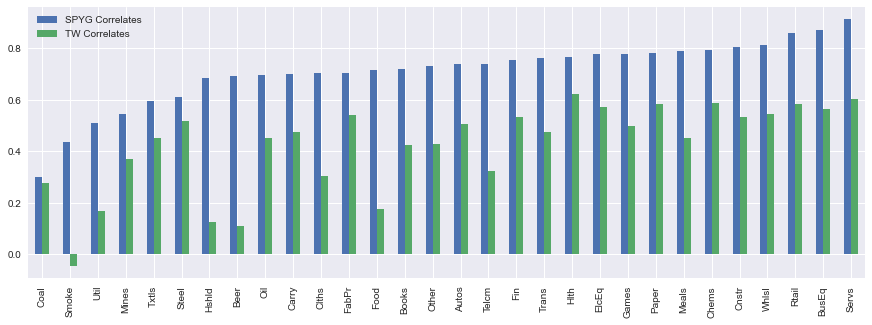

In [1573]:
sorted_spyg_correlates = ff_industries.corrwith(monthly_returns(bench_close['SPYG']) \
    .reindex(ff_industries.index)).sort_values()

port_correlates = ff_industries.corrwith(port_rets.reindex(ff_industries.index))

pd.DataFrame({
    'SPYG Correlates': sorted_spyg_correlates,
    'TW Correlates': port_correlates[sorted_spyg_correlates.index]
}).plot.bar()
# sorted_spyg_correlates.plot.bar()
# .plot.bar(color='green', alpha=1)

# Pyfolio

Experimenting with PyFolio

In [121]:
import pyfolio

/Users/mhandley/Envs/proteus-financial3.9/lib/python3.9/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


In [578]:
periods = n_day_periods(close_prices.index, 0, 10)

p = run_strategy(periods, close_prices.iloc[1:], satisfies)
bp = run_strategy(periods, bench_close, benchmark_satisfies)

In [569]:
p_returns = p.returns.mean(axis=1)
bp_returns = bp.returns.mean(axis=1)

<AxesSubplot:xlabel='date'>

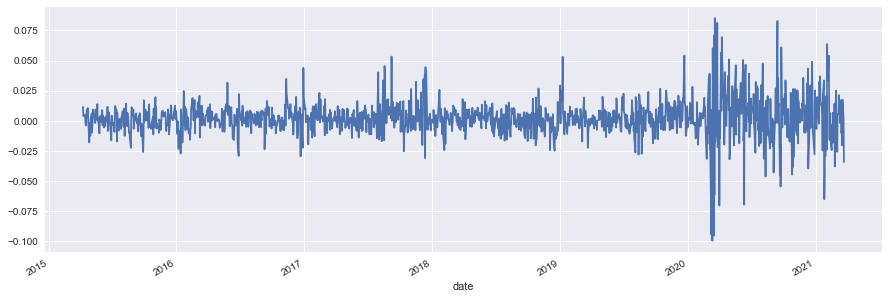

In [570]:
p.daily_returns.plot()

Start date,2015-04-16
End date,2021-03-16
Total months,70
,Backtest
Annual return,53.668%
Cumulative returns,1168.256%
Annual volatility,23.761%
Sharpe ratio,1.93
Calmar ratio,1.42
Stability,0.97
Max drawdown,-37.681%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,37.68,2020-02-20,2020-03-18,2020-05-11,58
1,18.51,2020-08-05,2020-09-04,2020-11-25,81
2,18.5,2021-02-08,2021-03-04,NaT,NaN
3,16.02,2018-09-10,2018-12-24,2019-02-04,106
4,13.84,2015-08-17,2016-02-11,2016-04-01,165


Stress Events,mean,min,max
Fall2015,-0.22%,-2.58%,1.94%
New Normal,0.18%,-13.14%,8.51%


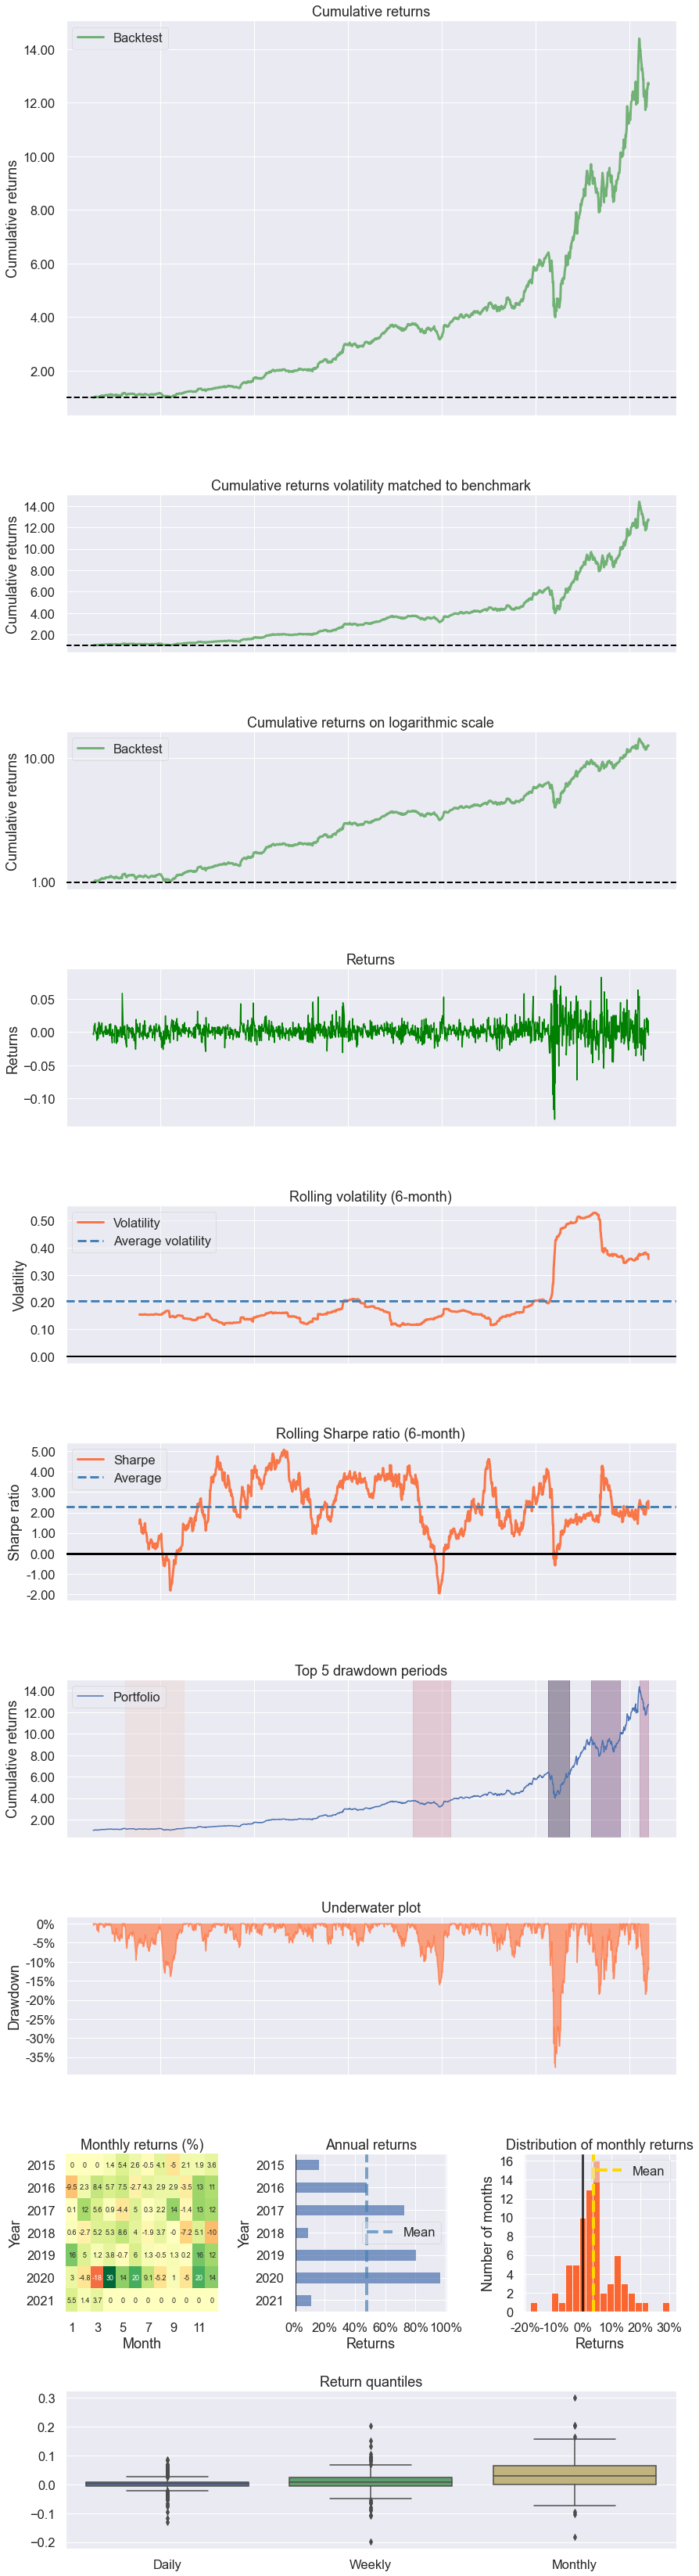

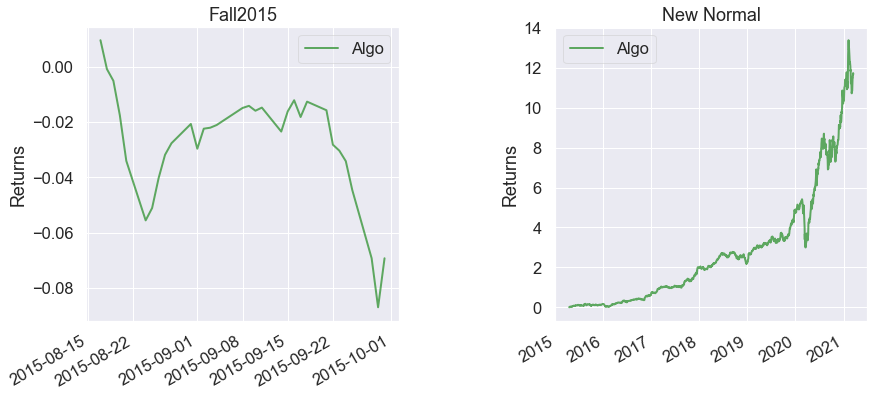

In [579]:
pyfolio.create_full_tear_sheet(p.daily_returns)

Start date,2015-01-20
End date,2021-03-16
Total months,73
,Backtest
Annual return,13.424%
Cumulative returns,117.008%
Annual volatility,18.354%
Sharpe ratio,0.78
Calmar ratio,0.39
Stability,0.93
Max drawdown,-33.992%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,33.99,2020-02-19,2020-03-23,2020-08-24,134
1,19.2,2018-09-20,2018-12-24,2019-04-12,147
2,13.02,2015-07-20,2016-02-11,2016-04-19,197
3,10.04,2018-01-26,2018-02-08,2018-08-06,137
4,8.88,2020-09-02,2020-09-23,2020-11-09,49


Stress Events,mean,min,max
Fall2015,-0.25%,-3.96%,3.82%
New Normal,0.06%,-11.58%,9.31%


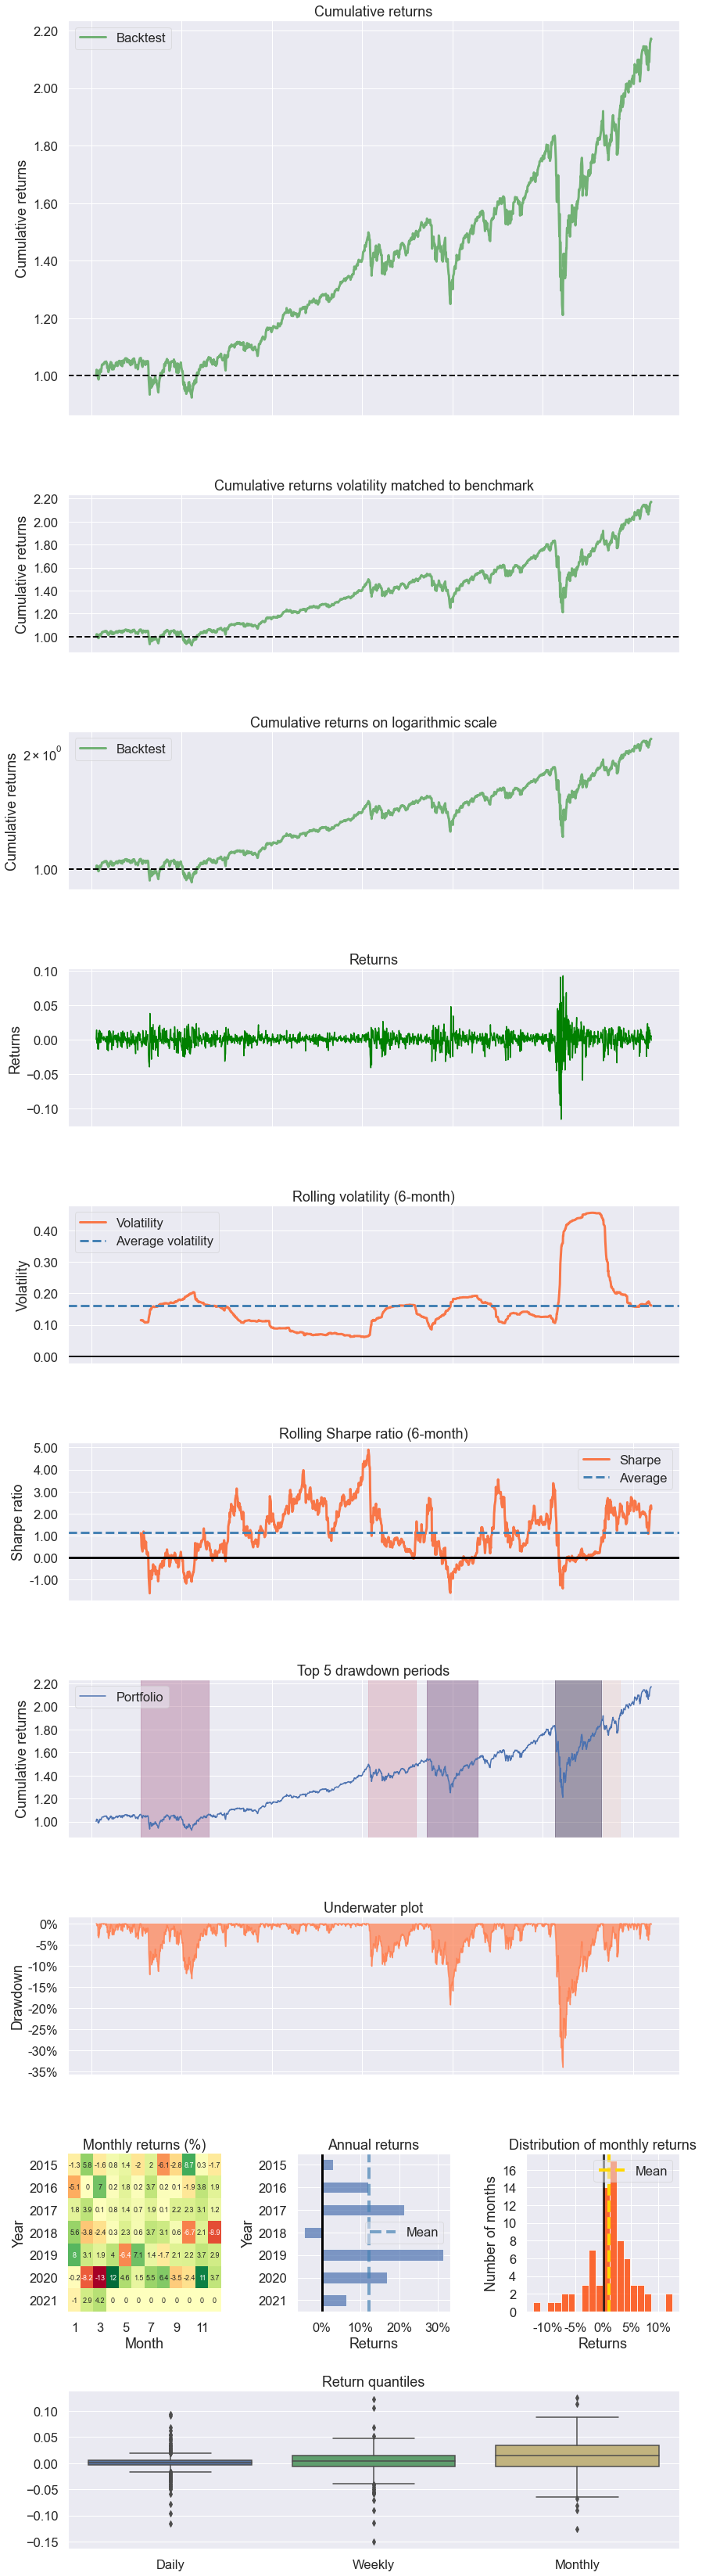

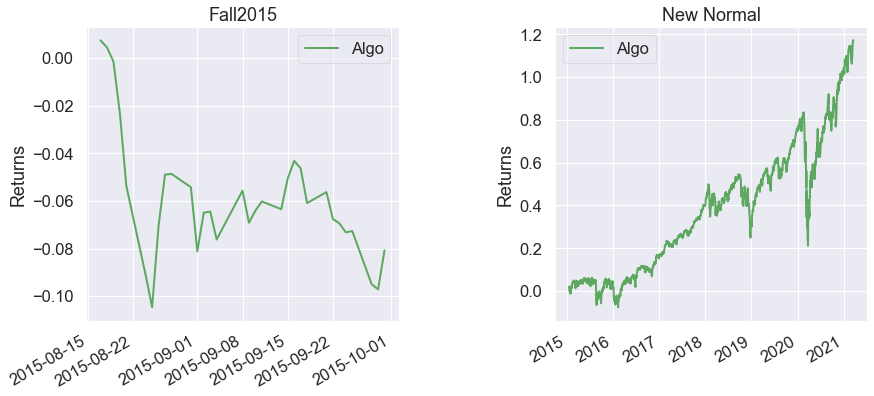

In [580]:
pyfolio.create_full_tear_sheet(bp.daily_returns)

## No rebalancing

As a control

In [733]:
date = '2015-06-17'
fixed_holdings = satisfies.columns[satisfies.loc[date]]
print(len(fixed_holdings), 'holdings')
fixed_holdings[:20]

50 holdings


Index(['ALRS', 'AMRS', 'APYX', 'ARAY', 'ASPN', 'ATEN', 'BCBP', 'BFC', 'BLDR',
       'CDXC', 'CE', 'CFFI', 'CHMI', 'CHTR', 'CONN', 'CVCY', 'ESXB', 'EVI',
       'FARO', 'FFWM'],
      dtype='object', name='symbols')

Start date,2016-06-17
End date,2021-03-23
Total months,57
,Backtest
Annual return,24.214%
Cumulative returns,180.58%
Annual volatility,26.1%
Sharpe ratio,0.96
Calmar ratio,0.52
Stability,0.62
Max drawdown,-46.563%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,46.56,2020-02-13,2020-03-18,2020-10-08,171
1,24.36,2018-09-21,2018-12-24,2019-11-13,299
2,10.64,2016-09-28,2016-11-03,2016-11-15,35
3,9.73,2018-01-23,2018-02-08,2018-06-12,101
4,7.14,2016-06-23,2016-06-27,2016-07-08,12


Stress Events,mean,min,max
New Normal,0.10%,-16.03%,10.99%


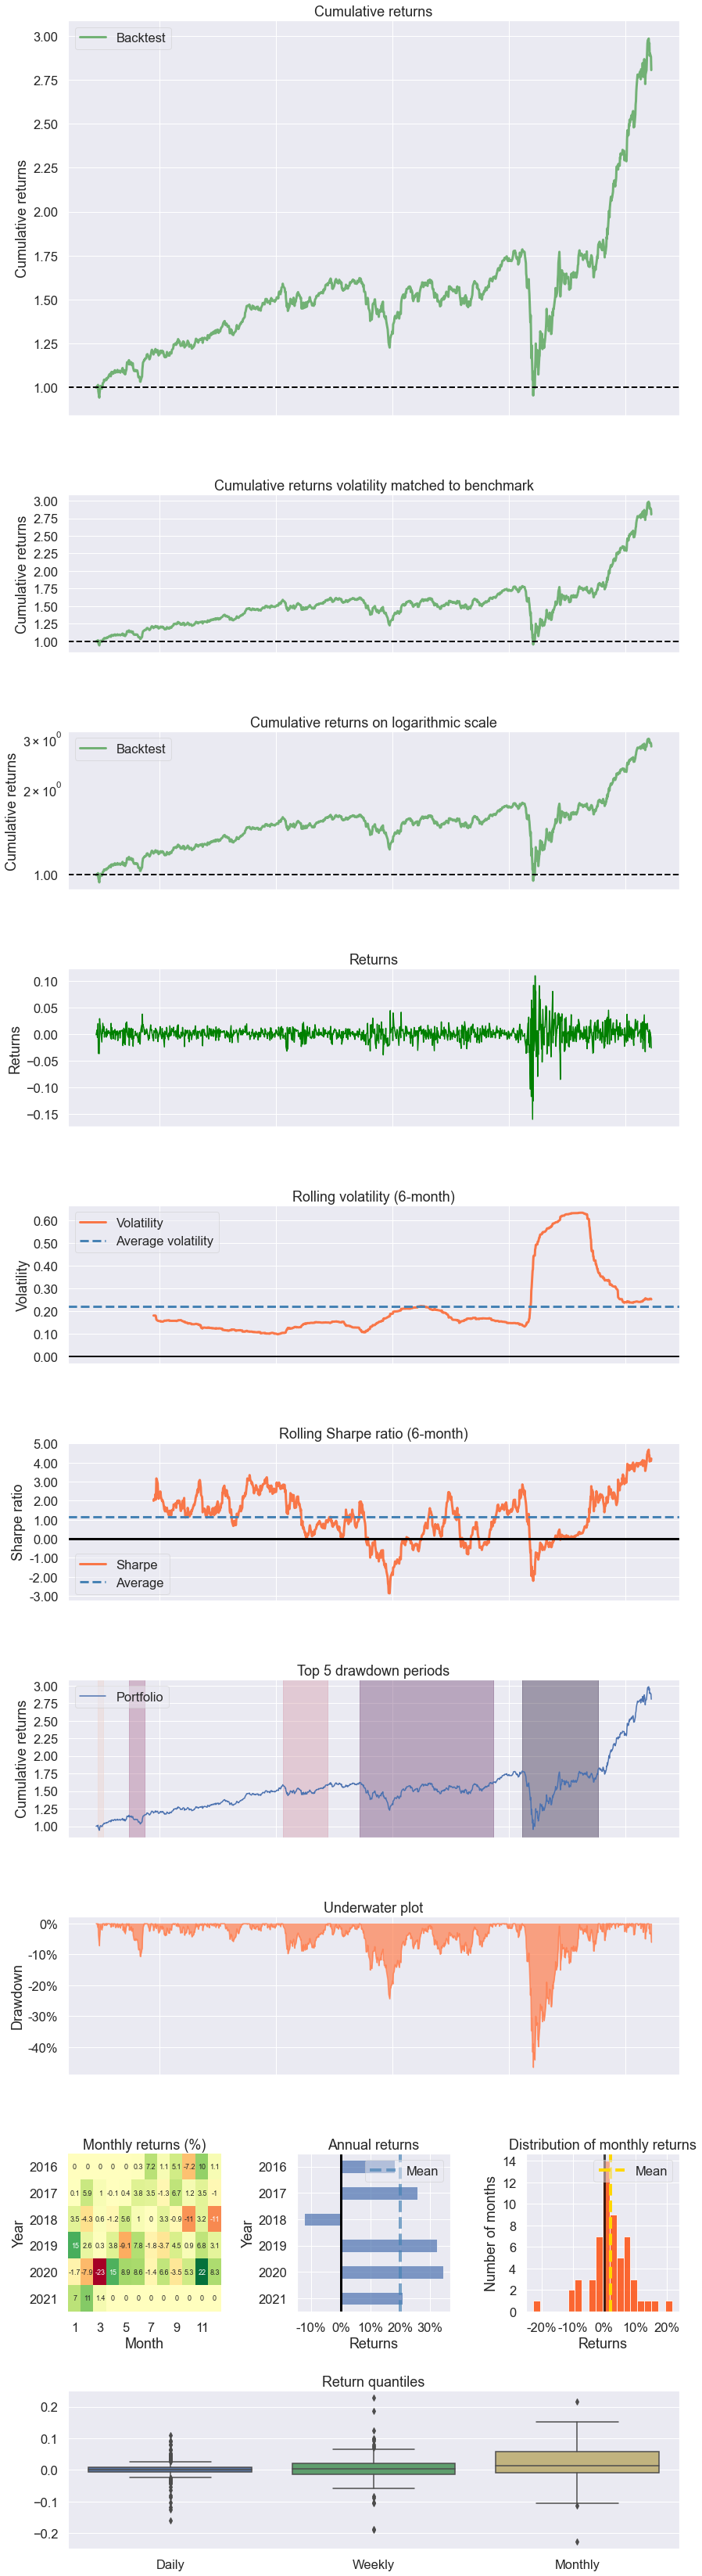

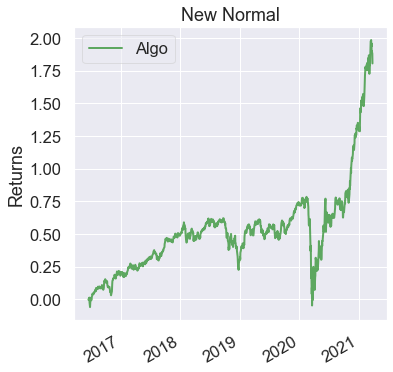

In [246]:
pyfolio.create_full_tear_sheet(returns.loc[date:, holdings].mean(axis=1))

In [738]:
periods = n_day_periods(close_prices.index, 0, 10)
p_no_rebalance = run_strategy(
    periods, close_prices, pd.DataFrame(True, index=satisfies.index, columns=fixed_holdings))

In [739]:
p_no_rebalance.stats()

{'mean': 0.0011762974166310506,
 'stddev': 0.01505750046957721,
 'sharpe': 1.2401223318072572,
 'num_traded_days': 155}

In [736]:
from pyfolio.plotting import show_perf_stats

In [740]:
show_perf_stats(p_no_rebalance.daily_returns.loc['2015-04-07':])

Start date,2015-04-07
End date,2021-03-16
Total months,71
,Backtest
Annual return,30.982%
Cumulative returns,396.92%
Annual volatility,24.265%
Sharpe ratio,1.24
Calmar ratio,0.65
Stability,0.88
Max drawdown,-47.936%


In [741]:
show_perf_stats(p.daily_returns)

Start date,2015-04-07
End date,2021-03-23
Total months,71
,Backtest
Annual return,42.954%
Cumulative returns,741.443%
Annual volatility,22.587%
Sharpe ratio,1.7
Calmar ratio,1.43
Stability,0.94
Max drawdown,-30.107%


In [641]:
date = '2017-01-05'
holdings = satisfies.columns[satisfies.loc[date]]
random_holdings = satisfies.columns.to_series().sample(60)
# fixed_p_returns = returns.loc[date:, holdings].mean(axis=1)
fixed_p_returns = p_no_rebalance.returns.mean(axis=1)
random_p_returns = returns.loc[date:, random_holdings].mean(axis=1)

<AxesSubplot:xlabel='date'>

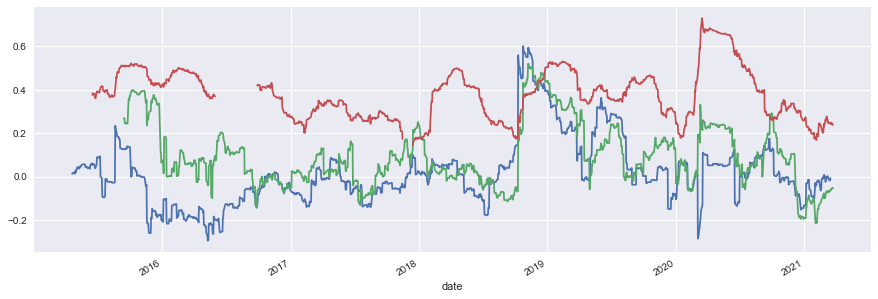

In [605]:
fixed_p_returns.rolling(63).corr(bench_returns['SPYG']).plot()
p_returns.loc[date:].rolling(63).corr(bench_returns['SPYG']).plot()
# bench_returns.loc[date:, 'RUA'].rolling(63).corr(bench_returns['SPYG']).plot()
corrs['SPYG'].loc[date:].mean(axis=1).plot()

<AxesSubplot:label='a544846f-42b7-4320-952c-c44a5a612115', xlabel='date'>

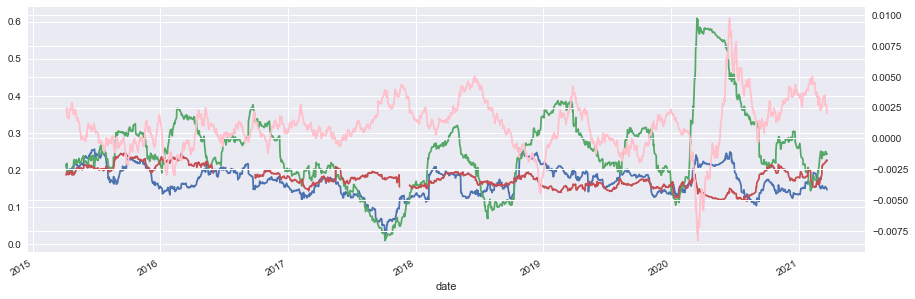

In [660]:
date = '2017-10-05'
holdings = satisfies.columns[satisfies.loc[date]]

random_holdings = satisfies.columns.to_series().sample(60)
corrs['SPYG'][holdings].std(axis=1).plot()
corrs['SPYG'][holdings].mean(axis=1).plot()
corrs['SPYG'][random_holdings].std(axis=1).plot()
plt.twinx()
returns[holdings].mean(axis=1).rolling(63).mean().plot(color='pink')

In [718]:
periods = n_day_periods(returns.index, 0, 2)

p = run_strategy(periods, close_prices, satisfies)

<AxesSubplot:label='2787b944-430d-47dc-a4d9-cfab80715a9e', xlabel='date'>

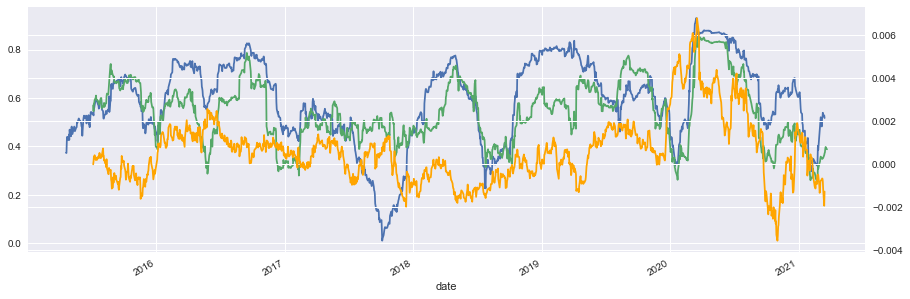

In [721]:
# p.holdings.apply(lambda holdings: corrs['SPYG'].loc[holdings.name, holdings.index[holdings == 1]].mean(), axis=1).plot()
p_no_rebalance.daily_returns.rolling(63).corr(bench_returns['SPYG']).plot()
p.daily_returns.rolling(63).corr(bench_returns['SPYG']).plot()
plt.twinx()
# p.daily_returns.rolling(63).apply(sortino_ratio).plot(color='orange')
(p.daily_returns - p_no_rebalance.daily_returns).rolling(63).mean().plot(color='orange')

## Fixed # of holdings

In [783]:
periods = n_day_periods(returns.index, 1, 10)
p_fixed_100 = run_strategy(periods, close_prices, satisfies_fixed_100)
p_fixed_200 = run_strategy(periods, close_prices, satisfies_fixed_200)
p_fixed_20 = run_strategy(periods, close_prices, satisfies_fixed_20)

In [801]:
print(p_fixed_100.stats())
print(p_fixed_200.stats())
print(p_fixed_20.stats())

{'mean': 0.001508142526673723, 'stddev': 0.013074347942896764, 'sharpe': 1.8311445058583327, 'num_traded_days': 149}
{'mean': 0.0014783895728558516, 'stddev': 0.013212400644529257, 'sharpe': 1.7762636431709342, 'num_traded_days': 149}
{'mean': 0.0014158506179100297, 'stddev': 0.015577874420466957, 'sharpe': 1.4428112054949216, 'num_traded_days': 149}


In [779]:
show_perf_stats(p_fixed_100.daily_returns)

Start date,2015-04-20
End date,2021-03-18
Total months,70
,Backtest
Annual return,43.075%
Cumulative returns,731.386%
Annual volatility,20.755%
Sharpe ratio,1.83
Calmar ratio,1.28
Stability,0.94
Max drawdown,-33.772%


In [780]:
show_perf_stats(p_fixed_200.daily_returns)

Start date,2015-04-20
End date,2021-03-18
Total months,70
,Backtest
Annual return,41.933%
Cumulative returns,692.922%
Annual volatility,20.974%
Sharpe ratio,1.78
Calmar ratio,1.2
Stability,0.95
Max drawdown,-34.901%


In [ ]:
satisfies_fixed_2 = bottom_k_total_corr_criteria(corr['SPYG'], corr['SPYV'], 2)
print(p_fixed_2.stats())
p_fixed_2 = run_strategy(periods, close_prices, satisfies_fixed_2)

In [800]:
show_perf_stats(p_fixed_2.daily_returns)

Start date,2015-04-20
End date,2021-03-18
Total months,70
,Backtest
Annual return,122.916%
Cumulative returns,11340.723%
Annual volatility,84.765%
Sharpe ratio,1.32
Calmar ratio,2.58
Stability,0.89
Max drawdown,-47.67%


## Taking the _top_ correlates

As a control

In [799]:
def top_k_total_corr_criteria(corrs1, corrs2, k):
    """Opposite of `bottom_k_total_corr_criteria`: take the top `k`
    correlates.
    """
    max_corr = corrs1.columns.to_series().apply(
        lambda tick: np.maximum(corrs1.abs()[tick], corrs2.abs()[tick])).T

    return max_corr.apply(lambda series: series.rank() > (series.rank().max() - k), axis=1)


In [794]:
satisfies_fixed_100_flip = top_k(corrs['SPYV'], corrs['SPYG'], 100)

p_flipped = run_strategy(periods, close_prices, satisfies_fixed_100_flip)
p_flipped.stats()

In [803]:
show_perf_stats(p_flipped.daily_returns)

Start date,2015-04-20
End date,2021-03-18
Total months,70
,Backtest
Annual return,12.06%
Cumulative returns,96.055%
Annual volatility,24.59%
Sharpe ratio,0.59
Calmar ratio,0.27
Stability,0.65
Max drawdown,-45.434%
